# Demo on PBMC dataset

In [128]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
import os,sys
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import scipy

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import q2r_uncertainty
import diff2atlas


In [142]:
import celltypist
import milopy

In [131]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import anndata2ri
anndata2ri.activate()

In [132]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [133]:
%%R
library(tidyverse)
library(patchwork)

In [203]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

### Load dataset

Built in [here](https://github.com/emdann/query2reference_uncertainty/blob/master/notebooks/PBMC_metanalysis/20220531_PBMC_metadata.ipynb)

In [7]:
data_dir = '/nfs/team205/ed6/data/PBMC_CZI_integration_filtered/'
adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.h5ad')

In [8]:
sample_obs = pd.read_csv(data_dir + 'PBMC_sample_metadata.normal.csv')

In [9]:
%%R -i sample_obs
dim(sample_obs)

[1] 1268   11


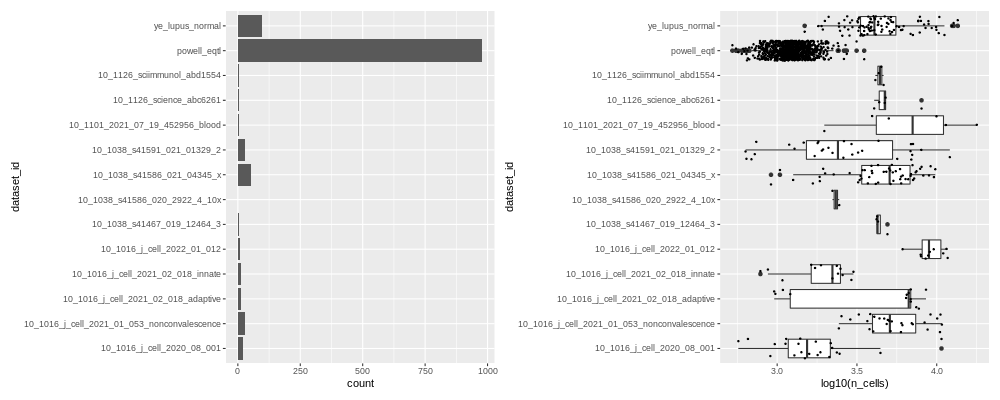

In [10]:
%%R -w 1000 -h 400
sample_obs %>%
    ggplot(aes(dataset_id)) +
    geom_bar( ) +
    coord_flip() +
sample_obs %>%
ggplot(aes(dataset_id, log10(n_cells))) +
geom_boxplot() +
geom_jitter(size=0.5) +
scale_fill_viridis_c() +
coord_flip()

### Design

- select one dataset to be query
- split in perturb and control (don't use two different datasets for now, otherwise you need to match)
- remove query-specific cluster from control and reference  

In [64]:
batch_obs = 'dataset_id'
query_dataset = '10_1038_s41591_021_01329_2' ## Stephenson et al

## Select query batch
query = np.array([s in query_dataset for s in adata.obs[batch_obs]])
adata.obs["is_train"] = (~query).astype(int)
adata.obs["is_test"] = query.astype('int')

## Split in case and ctrl
np.random.seed(40)
query_samples = sample_obs[sample_obs.dataset_id == query_dataset].sample_id
samples_design = np.random.choice((0,1), len(query_samples))
adata.obs['is_ctrl'] = adata.obs['sample_id'].isin(query_samples[samples_design==1]).astype(int)
adata.obs.loc[adata.obs['is_ctrl'] == 1, 'is_test'] = 0

In [65]:
sample_obs.index = sample_obs.sample_id.copy()
sample_obs.loc[query_samples[samples_design==1]]

sample_id     sex tissue ethnicity disease  \
sample_id                                                       
BGCV01_CV0904  BGCV01_CV0904  female  blood   unknown  normal   
BGCV02_CV0902  BGCV02_CV0902    male  blood   unknown  normal   
BGCV04_CV0911  BGCV04_CV0911  female  blood   unknown  normal   
BGCV10_CV0939  BGCV10_CV0939    male  blood   unknown  normal   
BGCV13_CV0934  BGCV13_CV0934  female  blood   unknown  normal   
BGCV15_CV0944  BGCV15_CV0944    male  blood   unknown  normal   
MH8919176          MH8919176  female  blood   unknown  normal   
MH8919178          MH8919178    male  blood   unknown  normal   
MH8919179          MH8919179    male  blood   unknown  normal   
MH8919226          MH8919226    male  blood   unknown  normal   
MH8919227          MH8919227    male  blood   unknown  normal   
MH8919230          MH8919230    male  blood   unknown  normal   
MH8919278          MH8919278    male  blood   unknown  normal   
MH8919279          MH8919279    male  blood   unknown  normal   
MH8919280          MH8919280    male  blood   unknown  normal   
MH8919332          MH8919332  female  blood   unknown  normal   

                                        assay assay_ontology_term_id  \
sample_id                                                              
BGCV01_CV0904  10x 3' transcription profiling            EFO:0030003   
BGCV02_CV0902  10x 3' transcription profiling            EFO:0030003   
BGCV04_CV0911  10x 3' transcription profiling            EFO:0030003   
BGCV10_CV0939  10x 3' transcription profiling            EFO:0030003   
BGCV13_CV0934  10x 3' transcription profiling            EFO:0030003   
BGCV15_CV0944  10x 3' transcription profiling            EFO:0030003   
MH8919176      10x 3' transcription profiling            EFO:0030003   
MH8919178      10x 3' transcription profiling            EFO:0030003   
MH8919179      10x 3' transcription profiling            EFO:0030003   
MH8919226      10x 3' transcription profiling            EFO:0030003   
MH8919227      10x 3' transcription profiling            EFO:0030003   
MH8919230      10x 3' transcription profiling            EFO:0030003   
MH8919278      10x 3' transcription profiling            EFO:0030003   
MH8919279      10x 3' transcription profiling            EFO:0030003   
MH8919280      10x 3' transcription profiling            EFO:0030003   
MH8919332      10x 3' transcription profiling            EFO:0030003   

                donor_id                  dataset_id  \
sample_id                                              
BGCV01_CV0904     CV0904  10_1038_s41591_021_01329_2   
BGCV02_CV0902     CV0902  10_1038_s41591_021_01329_2   
BGCV04_CV0911     CV0911  10_1038_s41591_021_01329_2   
BGCV10_CV0939     CV0939  10_1038_s41591_021_01329_2   
BGCV13_CV0934     CV0934  10_1038_s41591_021_01329_2   
BGCV15_CV0944     CV0944  10_1038_s41591_021_01329_2   
MH8919176      MH8919176  10_1038_s41591_021_01329_2   
MH8919178      MH8919178  10_1038_s41591_021_01329_2   
MH8919179      MH8919179  10_1038_s41591_021_01329_2   
MH8919226      MH8919226  10_1038_s41591_021_01329_2   
MH8919227      MH8919227  10_1038_s41591_021_01329_2   
MH8919230      MH8919230  10_1038_s41591_021_01329_2   
MH8919278      MH8919278  10_1038_s41591_021_01329_2   
MH8919279      MH8919279  10_1038_s41591_021_01329_2   
MH8919280      MH8919280  10_1038_s41591_021_01329_2   
MH8919332      MH8919332  10_1038_s41591_021_01329_2   

                       development_stage  n_cells  
sample_id                                          
BGCV01_CV0904  fourth decade human stage     6853  
BGCV02_CV0902   sixth decade human stage     2599  
BGCV04_CV0911   fifth decade human stage     1905  
BGCV10_CV0939  eighth decade human stage     1719  
BGCV13_CV0934   third decade human stage     3408  
BGCV15_CV0944   sixth decade human stage      634  
MH8919176       third decade human stage     3217  
MH8919178       sixth decade human stage     7016  
MH8919179      fourth 

In [66]:
sample_obs.loc[query_samples[samples_design==0]]

sample_id     sex tissue ethnicity disease  \
sample_id                                                       
BGCV01_CV0902  BGCV01_CV0902    male  blood   unknown  normal   
BGCV05_CV0929  BGCV05_CV0929    male  blood   unknown  normal   
BGCV08_CV0915  BGCV08_CV0915  female  blood   unknown  normal   
BGCV09_CV0917  BGCV09_CV0917  female  blood   unknown  normal   
BGCV12_CV0926  BGCV12_CV0926  female  blood   unknown  normal   
BGCV14_CV0940  BGCV14_CV0940    male  blood   unknown  normal   
MH8919177          MH8919177  female  blood   unknown  normal   
MH8919231          MH8919231    male  blood   unknown  normal   
MH8919281          MH8919281    male  blood   unknown  normal   
MH8919282          MH8919282  female  blood   unknown  normal   
MH8919283          MH8919283  female  blood   unknown  normal   
MH8919333          MH8919333    male  blood   unknown  normal   
newcastle65      newcastle65  female  blood   unknown  normal   
newcastle74      newcastle74    male  blood   unknown  normal   

                                        assay assay_ontology_term_id  \
sample_id                                                              
BGCV01_CV0902  10x 3' transcription profiling            EFO:0030003   
BGCV05_CV0929  10x 3' transcription profiling            EFO:0030003   
BGCV08_CV0915  10x 3' transcription profiling            EFO:0030003   
BGCV09_CV0917  10x 3' transcription profiling            EFO:0030003   
BGCV12_CV0926  10x 3' transcription profiling            EFO:0030003   
BGCV14_CV0940  10x 3' transcription profiling            EFO:0030003   
MH8919177      10x 3' transcription profiling            EFO:0030003   
MH8919231      10x 3' transcription profiling            EFO:0030003   
MH8919281      10x 3' transcription profiling            EFO:0030003   
MH8919282      10x 3' transcription profiling            EFO:0030003   
MH8919283      10x 3' transcription profiling            EFO:0030003   
MH8919333      10x 3' transcription profiling            EFO:0030003   
newcastle65    10x 3' transcription profiling            EFO:0030003   
newcastle74    10x 3' transcription profiling            EFO:0030003   

                  donor_id                  dataset_id  \
sample_id                                                
BGCV01_CV0902       CV0902  10_1038_s41591_021_01329_2   
BGCV05_CV0929       CV0929  10_1038_s41591_021_01329_2   
BGCV08_CV0915       CV0915  10_1038_s41591_021_01329_2   
BGCV09_CV0917       CV0917  10_1038_s41591_021_01329_2   
BGCV12_CV0926       CV0926  10_1038_s41591_021_01329_2   
BGCV14_CV0940       CV0940  10_1038_s41591_021_01329_2   
MH8919177        MH8919177  10_1038_s41591_021_01329_2   
MH8919231        MH8919231  10_1038_s41591_021_01329_2   
MH8919281        MH8919281  10_1038_s41591_021_01329_2   
MH8919282        MH8919282  10_1038_s41591_021_01329_2   
MH8919283        MH8919283  10_1038_s41591_021_01329_2   
MH8919333        MH8919333  10_1038_s41591_021_01329_2   
newcastle65    newcastle65  10_1038_s41591_021_01329_2   
newcastle74    newcastle74  10_1038_s41591_021_01329_2   

                        development_stage  n_cells  
sample_id                                           
BGCV01_CV0902    sixth decade human stage     1285  
BGCV05_CV0929  seventh decade human stage     1466  
BGCV08_CV0915    fifth decade human stage     1940  
BGCV09_CV0917  seventh decade human stage     2924  
BGCV12_CV0926  seventh decade human stage     2622  
BGCV14_CV0940  seventh decade human stage     2958  
MH8919177        sixth decade human stage     2223  
MH8919231       fourth decade human stage      690  
MH8919281        third decade human stage      724  
MH8919282       fourth decade human stage     6896  
MH8919283        third decade human stage     7100  
MH8919333        fifth decade human stage    12081  
newcastle65      sixth decade human stage     5655  
newcastle74      sixth decade human stage     6932

In [77]:
# Remove query-specific population from train and ctrl cells
population_obs = 'cell_type'
ct_size = adata.obs[['sample_id', 'is_ctrl', 'is_test', 'is_train', 'cell_type']].groupby(['sample_id', 'is_ctrl', 'is_test', 'is_train', 'cell_type']).size().reset_index()

In [80]:
ct_size = ct_size[ct_size[0] > 0]

In [88]:
ct_size['group'] = ct_size[['is_ctrl', 'is_test', 'is_train']].idxmax(1)

In [89]:
%%R -i ct_size
dim(ct_size)

[1] 23549     7


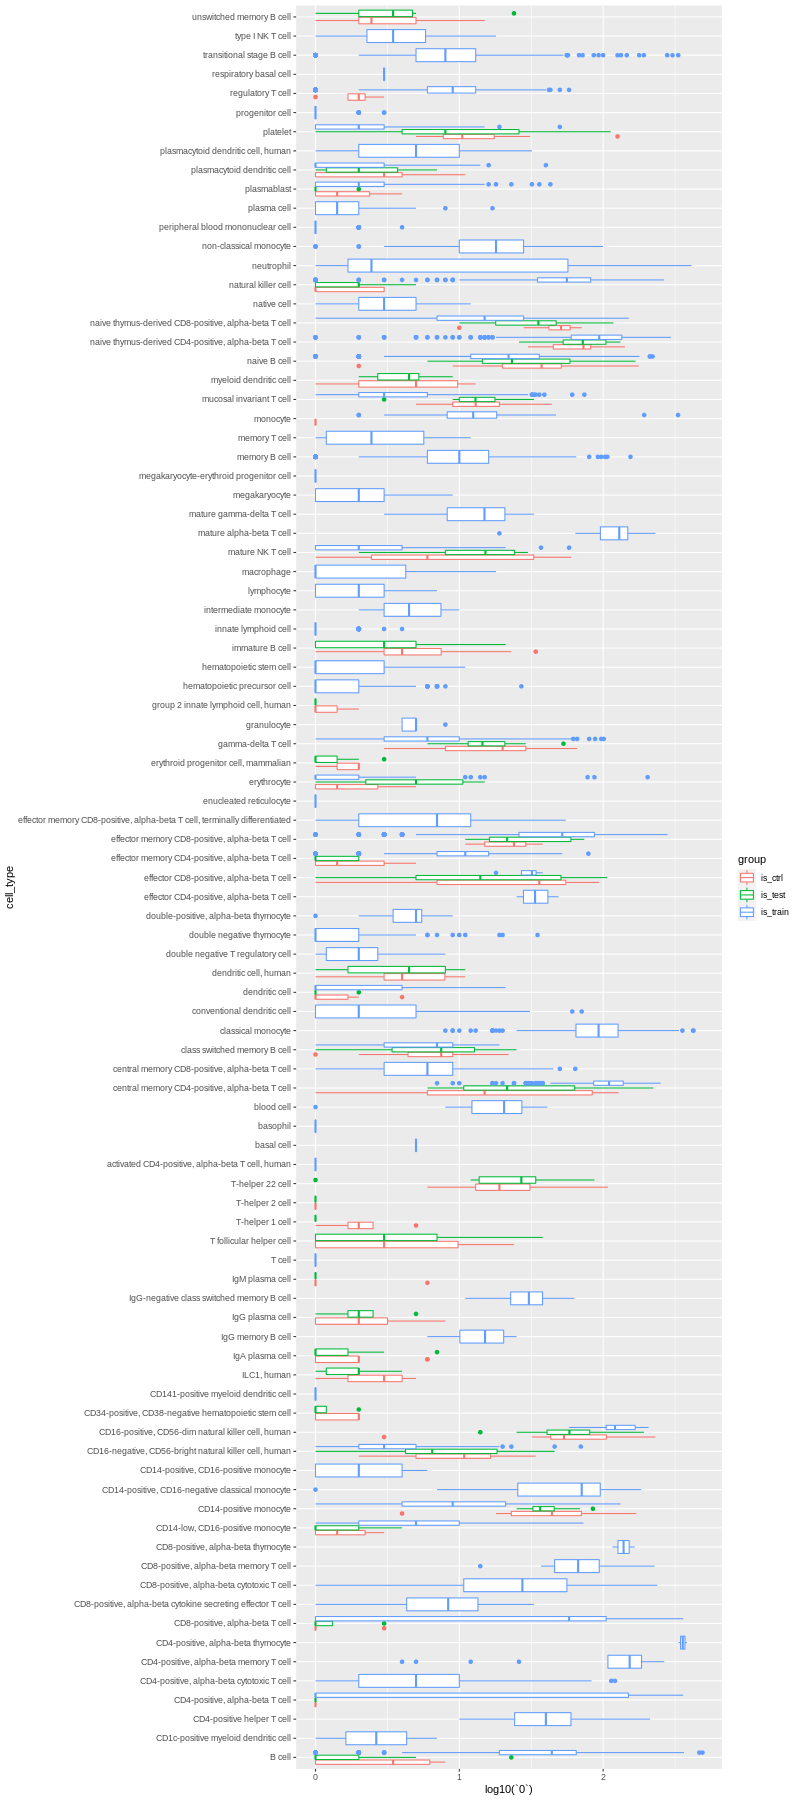

In [92]:
%%R -h 1800 -w 800
ct_size %>%
ggplot(aes(cell_type, log10(`0`))) +
geom_boxplot(aes(color=group)) +
coord_flip()

In [94]:
perturb_pop = ["naive B cell"]
adata.obs.loc[(adata.obs[population_obs].isin(perturb_pop)),
              'is_train'] = 0
adata.obs.loc[(adata.obs[population_obs].isin(
        perturb_pop)), 'is_ctrl'] = 0

In [112]:
# test that no cell is assigned to multiple splits
assert adata.obs[['is_train', 'is_test', 'is_ctrl']].sum(1).max() == 1

# test that perturbed population is in condition dataset only
assert adata[adata.obs['is_test'] == 1].obs[population_obs].isin(perturb_pop).sum() > 0
assert adata[adata.obs['is_train'] == 1].obs[population_obs].isin(perturb_pop).sum() == 0
assert adata[adata.obs['is_ctrl'] == 1].obs[population_obs].isin(perturb_pop).sum() == 0

In [120]:
adata_atlas = adata[adata.obs['is_train']==1].copy()
adata_ctrl = adata[adata.obs['is_ctrl']==1].copy()
adata_query = adata[adata.obs['is_test']==1].copy()

In [127]:
gdrive_dir = '/home/jovyan/mount/gdrive/query2reference/PBMC_CZIintegration_data/'
adata_atlas.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.atlas.h5ad')
adata_query.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.query.h5ad')
adata_ctrl.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.ctrl.h5ad')

With scVI/scArches
---

In [5]:
gdrive_dir = '/home/jupyter/mount/gdrive/query2reference/PBMC_CZIintegration_data/'
adata_atlas = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.atlas.h5ad')
adata_query = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.query.h5ad')
adata_ctrl = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.ctrl.h5ad')

### Atlas model

In [6]:
adata_atlas.X = adata_atlas.layers['counts'].copy()

In [7]:
del adata_atlas.uns['log1p']

In [8]:
## Feature selection on reference only
n_hvgs = 5000
overwrite_models = False

if 'log1p' not in adata_atlas.uns.keys():
    sc.pp.normalize_per_cell(adata_atlas)
    sc.pp.log1p(adata_atlas)

sc.pp.highly_variable_genes(
    adata_atlas,
    n_top_genes=n_hvgs,
    subset=True
)

In [9]:
hvgs = adata_atlas.var_names.values

In [10]:
## Some utils
def clean_pop_name(string):
   return(''.join(e if e.isalnum() else '_' for e in string))

In [11]:
population_obs = 'cell_type'
perturb_pop = ["naive B cell"]
sim_id = f"qPBMC_500cells_demo_perturb_{population_obs}{clean_pop_name('-'.join(perturb_pop))}"
sim_id
if not os.path.exists(gdrive_dir + sim_id + "_models"):
    os.mkdir(gdrive_dir + sim_id + "_models")

In [20]:
## Train reference model
if not os.path.exists(gdrive_dir + sim_id + "_models/model_reference") or overwrite_models:
    vae_ref = q2r_uncertainty.train_models.train_scVI._train_model(adata_atlas, hvgs, batch_col='sample_id')
    vae_ref.save(gdrive_dir + sim_id + "_models/model_reference", overwrite=True)

INFO     Using batches from adata.obs["batch"]                                               


Using batches from adata.obs["batch"]


INFO     No label_key inputted, assuming all cells have same label                           


No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 589174 cells, 5000 vars, 1225     
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 589174 cells, 5000 vars, 1225 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14/14: 100%|██████████| 14/14 [09:30<00:00, 40.73s/it, loss=1.09e+03, v_num=1]


In [16]:
adata_atlas.obs['batch'] = adata_atlas.obs['sample_id'].copy()

In [17]:
vae_ref = scvi.model.SCVI.load(gdrive_dir + sim_id + "_models/model_reference", adata=adata_atlas)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 589174 cells, 5000 vars, 1225     
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 589174 cells, 5000 vars, 1225 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


In [21]:
adata_ctrl.layers['counts'] = adata_ctrl.X.copy()
adata_query.layers['counts'] = adata_query.X.copy()

In [22]:
## Map query datasets 
vae_ctrl_fit = q2r_uncertainty.train_models.train_scVI._fit_model(adata_ctrl, vae_ref, batch_col='sample_id')
vae_ctrl_fit.save(gdrive_dir + sim_id + "_models/model_fit_ctrl/", overwrite=True)
vae_query_fit_ref = q2r_uncertainty.train_models.train_scVI._fit_model(adata_query, vae_ref, batch_col='sample_id')
vae_query_fit_ref.save(gdrive_dir + sim_id + "_models/model_fit_query/", overwrite=True)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 7214 cells, 5000 vars, 1241       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 7214 cells, 5000 vars, 1241 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [01:32<00:00,  2.16it/s, loss=1.6e+03, v_num=1] 
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 7000 cells, 5000 vars, 1239       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 7000 cells, 5000 vars, 1239 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [01:32<00:00,  2.17it/s, loss=1.5e+03, v_num=1] 


### Control model

In [24]:
## Feature selection on reference only
n_hvgs = 5000
overwrite_models = False

if 'log1p' not in adata_ctrl.uns.keys():
    sc.pp.normalize_per_cell(adata_ctrl)
    sc.pp.log1p(adata_ctrl)

sc.pp.highly_variable_genes(
    adata_ctrl,
    n_top_genes=n_hvgs,
    subset=True
)

In [25]:
hvgs = adata_ctrl.var_names.values

In [28]:
## Train reference model
if not os.path.exists(gdrive_dir + sim_id + "_models/model_ctrl") or overwrite_models:
    vae_ctrl = q2r_uncertainty.train_models.train_scVI._train_model(adata_ctrl, hvgs, batch_col='sample_id')
    vae_ctrl.save(gdrive_dir + sim_id + "_models/model_ctrl", overwrite=True)

INFO     Using batches from adata.obs["batch"]                                               


Using batches from adata.obs["batch"]


INFO     No label_key inputted, assuming all cells have same label                           


No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 7214 cells, 5006 vars, 16 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Successfully registered anndata object containing 7214 cells, 5006 vars, 16 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [03:18<00:00,  2.02it/s, loss=1.45e+03, v_num=1]


In [29]:
vae_query_fit_ctrl = q2r_uncertainty.train_models.train_scVI._fit_model(adata_query, vae_ctrl, batch_col='sample_id')
vae_query_fit_ctrl.save(gdrive_dir + sim_id + "_models/model_fit_query_2ctrl/", overwrite=True)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 7000 cells, 5006 vars, 30 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Successfully registered anndata object containing 7000 cells, 5006 vars, 30 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [01:26<00:00,  2.32it/s, loss=1.46e+03, v_num=1]


### Co-embeddings

In [31]:
adata_atlas = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.atlas.h5ad')
adata_query = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.query.h5ad')
adata_ctrl = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.ctrl.h5ad')

In [46]:
## perturbation-atlas
pa_design_adata = adata_atlas.concatenate(adata_query, batch_key='dataset', batch_categories=['atlas', 'query'])
pa_design_adata.layers['counts'] = pa_design_adata.X.copy()
pa_design_adata.obs['batch'] = pa_design_adata.obs['sample_id'].copy()

In [47]:
pa_design_adata.obsm["X_scVI"] = vae_query_fit_ref.get_latent_representation(pa_design_adata[:,vae_query_fit_ref.adata.var_names])

INFO     Received view of anndata, making copy.                                              


Received view of anndata, making copy.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               


Input adata not setup with scvi. attempting to transfer anndata setup


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 596174 cells, 5000 vars, 1239     
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 596174 cells, 5000 vars, 1239 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


In [48]:
## perturbation-ctrl
pc_design_adata = adata_ctrl.concatenate(adata_query, batch_key='dataset', batch_categories=['ctrl', 'query'])
pc_design_adata.layers['counts'] = pc_design_adata.X.copy()
pc_design_adata.obs['batch'] = pc_design_adata.obs['sample_id'].copy()

In [49]:
pc_design_adata.obsm["X_scVI"] = vae_query_fit_ctrl.get_latent_representation(pc_design_adata[:,vae_query_fit_ctrl.adata.var_names])

INFO     Received view of anndata, making copy.                                              


Received view of anndata, making copy.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               


Input adata not setup with scvi. attempting to transfer anndata setup


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 14214 cells, 5006 vars, 30        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 14214 cells, 5006 vars, 30 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


In [50]:
## perturbation-ctrl
ac_design_adata = adata_atlas.concatenate(adata_ctrl, batch_key='dataset', batch_categories=['atlas', 'ctrl'])
ac_design_adata.layers['counts'] = ac_design_adata.X.copy()
ac_design_adata.obs['batch'] = ac_design_adata.obs['sample_id'].copy()

In [51]:
ac_design_adata.obsm["X_scVI"] = vae_ctrl_fit.get_latent_representation(ac_design_adata[:,vae_ctrl_fit.adata.var_names])

INFO     Received view of anndata, making copy.                                              


Received view of anndata, making copy.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               


Input adata not setup with scvi. attempting to transfer anndata setup


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 596388 cells, 5000 vars, 1241     
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 596388 cells, 5000 vars, 1241 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


In [52]:
pac_design_adata = pa_design_adata.concatenate(ac_design_adata)

In [53]:
for adata in [pa_design_adata, pc_design_adata, pac_design_adata]:
    sc.pp.neighbors(adata, n_neighbors=30, use_rep="X_scVI")
    sc.tl.umap(adata)

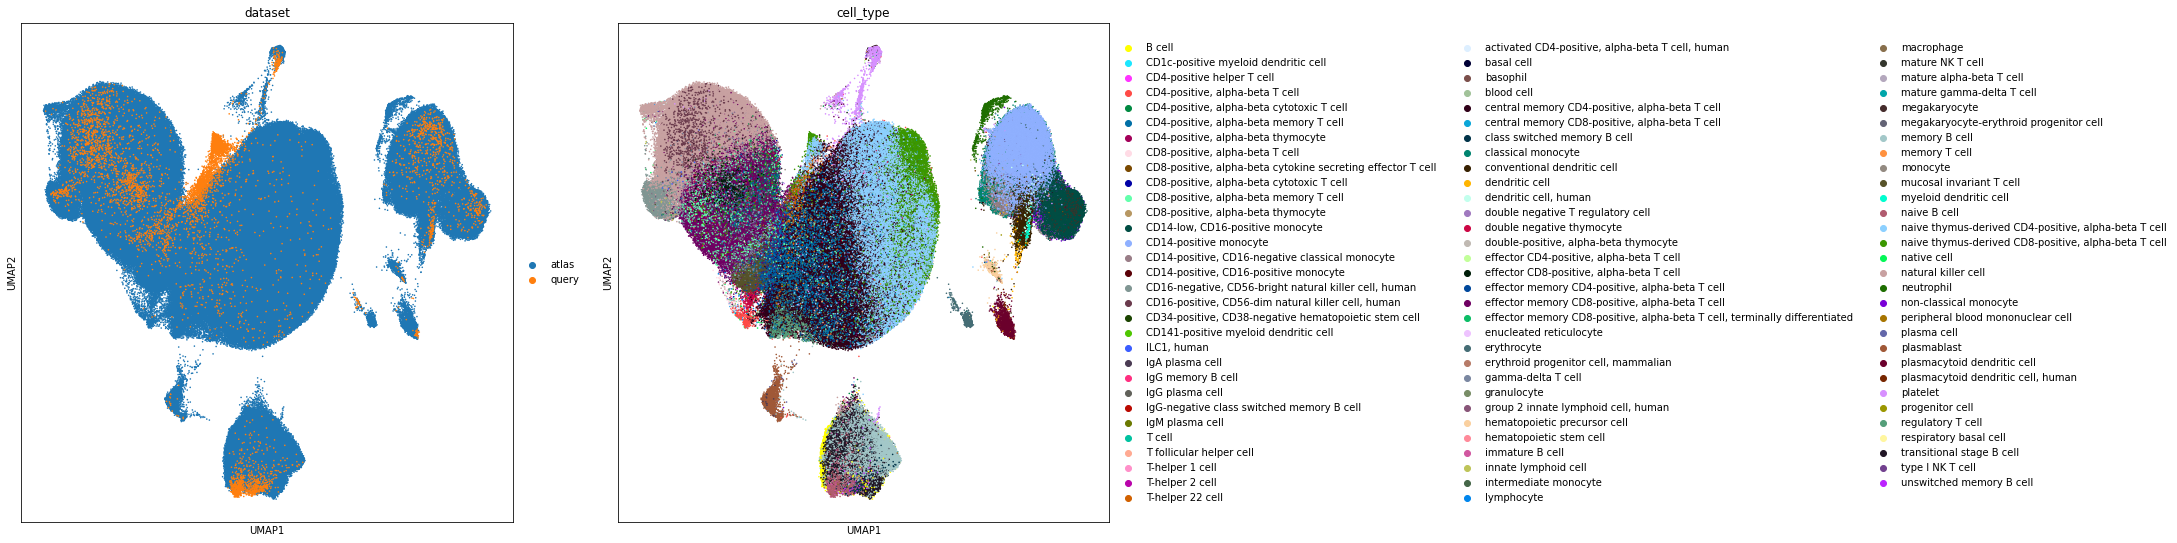

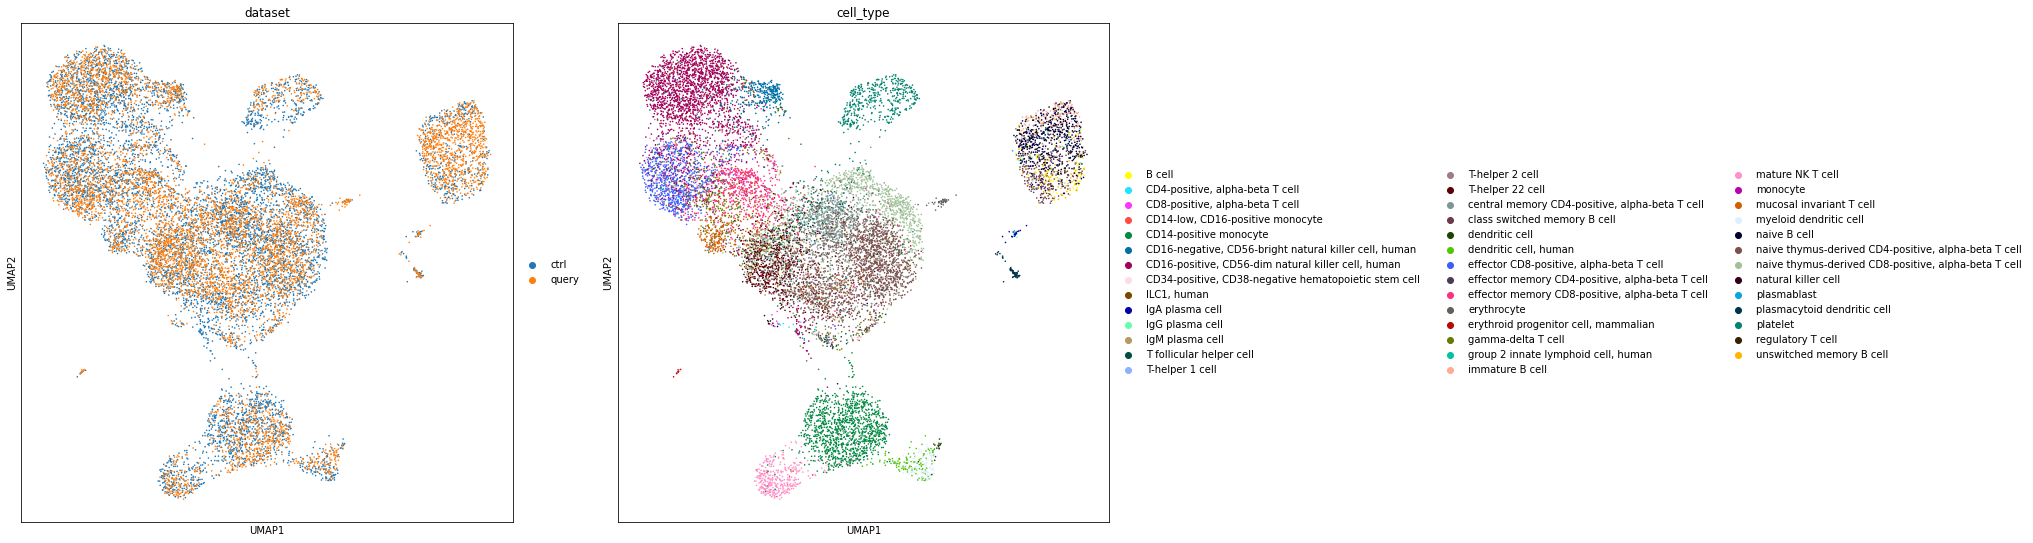

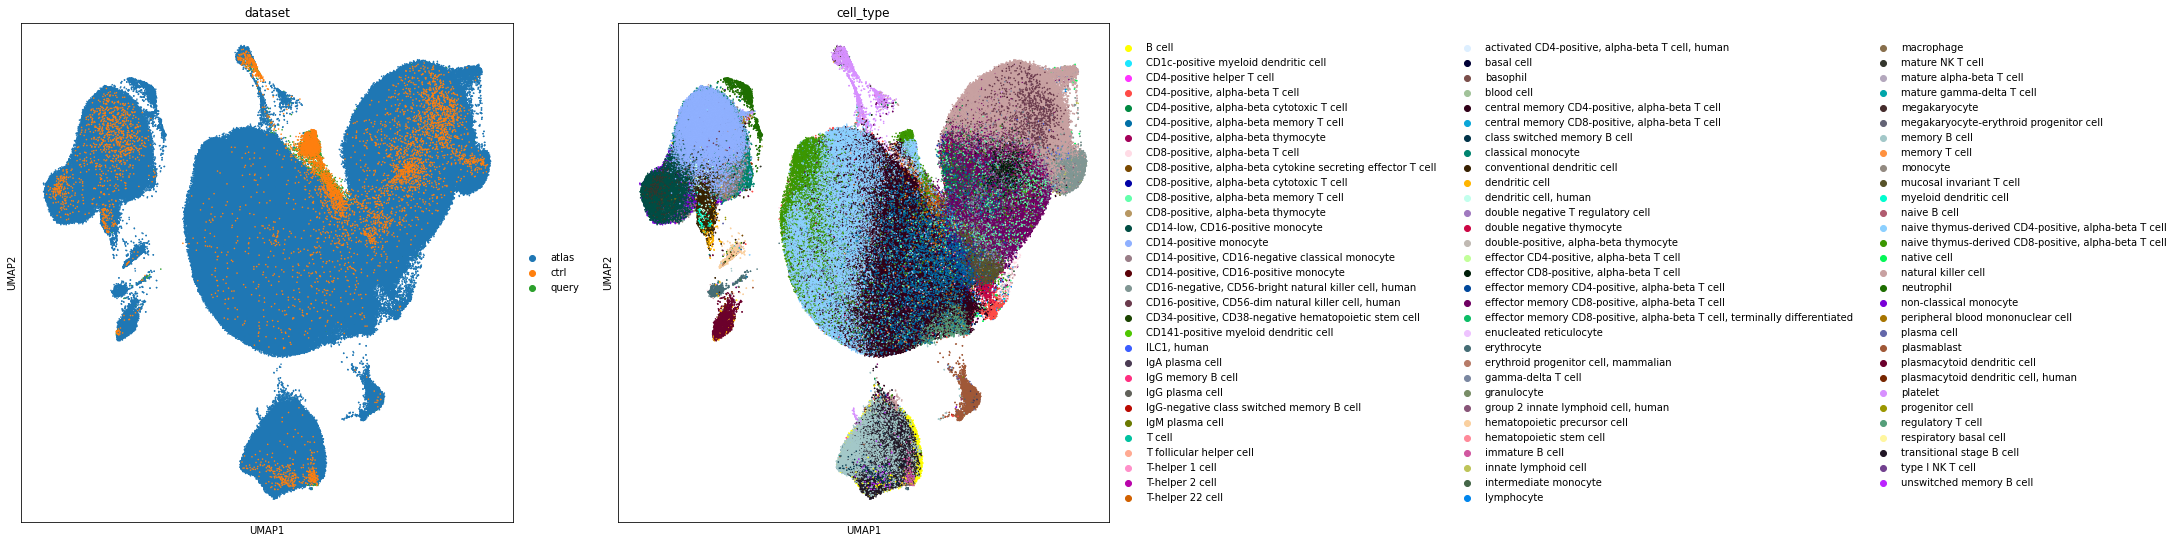

In [65]:
plt.rcParams['figure.figsize'] = [9,9]
sc.pl.umap(pa_design_adata, color=['dataset', 'cell_type'], size=10)
sc.pl.umap(pc_design_adata, color=['dataset', 'cell_type'], size=10)
sc.pl.umap(pac_design_adata, color=['dataset', 'cell_type'], size=10)

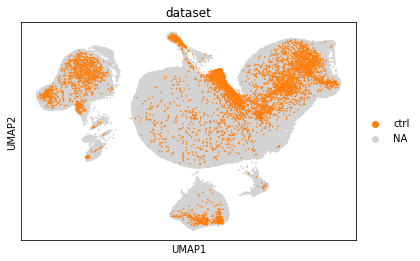

In [59]:
sc.pl.umap(pac_design_adata, color='dataset', size=10, groups=['ctrl'])

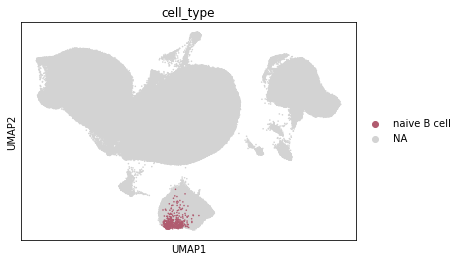

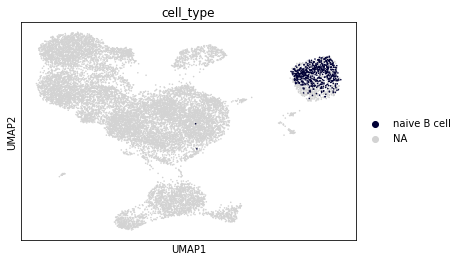

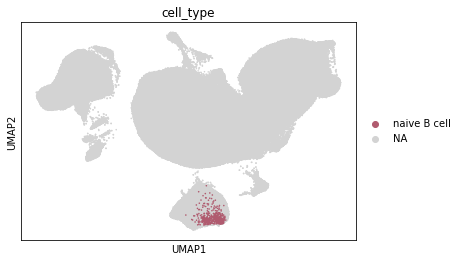

In [64]:
sc.pl.umap(pa_design_adata, color=population_obs, size=10, groups=perturb_pop)
sc.pl.umap(pc_design_adata, color=population_obs, size=10, groups=perturb_pop)
sc.pl.umap(pac_design_adata, color=population_obs, size=10, groups=perturb_pop)

### Quantify uncertainty

In [70]:
from q2r_uncertainty.uncertainty_metrics import scArches_uncertainty, KNNconservation, trueVSpred_gex_cosine 
from q2r_uncertainty.predict_gex import generative_posterior_mean

# pac_design_adata.obs['dataset_group'] = pac_design_adata.obs['dataset']
# pc_design_adata.obs['dataset_group'] = pc_design_adata.obs['dataset']
# pa_design_adata.obs['dataset_group'] = pa_design_adata.obs['dataset']

pa_design_adata.obs['dataset'] = ['reference' if x=='atlas' else 'query' for x in pa_design_adata.obs['dataset_group']] 
pc_design_adata.obs['dataset'] = ['reference' if x=='ctrl' else 'query' for x in pc_design_adata.obs['dataset_group']] 
pac_design_adata.obs['dataset'] = ['reference' if x=='atlas' else 'query' for x in pac_design_adata.obs['dataset_group']] 

pa_design_adata_q = pa_design_adata[pa_design_adata.obs['dataset'] == 'query'].copy()
pac_design_adata_q = pac_design_adata[pac_design_adata.obs['dataset'] == 'query'].copy()
pc_design_adata_q = pc_design_adata[pc_design_adata.obs['dataset'] == 'query'].copy()

In [80]:
pa_design_adata.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PA_design.coembedding.h5ad')
pac_design_adata.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PAC_design.coembedding.h5ad')
pc_design_adata.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PC_design.coembedding.h5ad')


... storing 'dataset' as categorical
... storing 'dataset' as categorical
... storing 'dataset' as categorical


In [68]:
## scArches label uncertainty
pa_design_adata.obs['scArches_unc'] = np.nan
pa_design_adata.obs.loc[pa_design_adata.obs.dataset == 'query', 'scArches_unc'] = scArches_uncertainty(merged_adata=pa_design_adata, q2r_emb='X_scVI', anno_col='cell_type')
pac_design_adata.obs['scArches_unc'] = np.nan
pac_design_adata.obs.loc[pac_design_adata.obs.dataset == 'query', 'scArches_unc'] = scArches_uncertainty(merged_adata=pac_design_adata, q2r_emb='X_scVI', anno_col='cell_type')
pc_design_adata.obs['scArches_unc'] = np.nan
pc_design_adata.obs.loc[pc_design_adata.obs.dataset == 'query', 'scArches_unc'] = scArches_uncertainty(merged_adata=pc_design_adata, q2r_emb='X_scVI', anno_col='cell_type')

5.672593593597412


MemoryError: Unable to allocate 30.7 GiB for an array with shape (7000, 589174) and data type float64

In [85]:
import sklearn.metrics
import scipy.sparse

def trueVSpred_gex_cosine(
    vae,
    n_samples=50,
    scale: bool = False
):
    '''
    Compute cosine distance between true and predicted gene expression profile

    Params:
    ------
    - adata: AnnData object
    - pred_layer: element in adata.layers storing predicted gene expression profile
    - true_layer: element in adata.layers storing true gene expression profile
    - scale: should gex profiles be scaled before computing the distance (== calculating correlation)    

    Returns:
    -------
    None, modifies adata in place adding `adata.obs['trueVSpred_gex_cosine']`
    '''
    adata = vae.adata.copy()
    if 'log1p' not in adata.uns.keys():
        sc.pp.normalize_per_cell(adata)
        sc.pp.log1p(adata)
    X_true = adata.X.copy()

    post_sample = vae.posterior_predictive_sample(n_samples=n_samples)
    post_sample = np.log1p(post_sample)
    X_pred = post_sample.mean(2)
    
    if scipy.sparse.issparse(X_true):
        X_true = X_true.toarray()
    if scipy.sparse.issparse(X_pred):
        X_pred = X_pred.toarray()

    if scale:
        X_pred = sc.pp.scale(X_pred, zero_center=False)
        X_true = sc.pp.scale(X_true, zero_center=False)

    cosine_all = sklearn.metrics.pairwise.cosine_distances(X_true, X_pred)
    adata.obs['trueVSpred_gex_cosine'] = np.diag(cosine_all)
    return(adata.obs['trueVSpred_gex_cosine'])

In [89]:
unc_fit_ctrl = trueVSpred_gex_cosine(vae_query_fit_ctrl, n_samples=50)
unc_fit_ref = trueVSpred_gex_cosine(vae_query_fit_ref, n_samples=50)
unc_ctrl = trueVSpred_gex_cosine(vae_ctrl_fit, n_samples=50)

In [124]:
pac_design_adata.obs['pred_unc'] = np.nan
pac_design_adata.obs.loc[unc_fit_ref.index +'-query-0', 'pred_unc'] = unc_fit_ref.values
pac_design_adata.obs.loc[unc_ctrl.index +'-ctrl-1', 'pred_unc'] = unc_ctrl.values

In [126]:
pa_design_adata.obs['pred_unc'] = np.nan
pa_design_adata.obs.loc[unc_fit_ref.index +'-query', 'pred_unc'] = unc_fit_ref.values

In [127]:
pc_design_adata.obs['pred_unc'] = np.nan
pc_design_adata.obs.loc[unc_fit_ctrl.index +'-query', 'pred_unc'] = unc_fit_ctrl.values

In [128]:
pa_design_adata.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PA_design.coembedding.h5ad')
pac_design_adata.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PAC_design.coembedding.h5ad')
pc_design_adata.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PC_design.coembedding.h5ad')

### Make nhoods

In [137]:
gdrive_dir = '/home/jovyan/mount/gdrive/query2reference/PBMC_CZIintegration_data/'
pa_design_adata = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PA_design.coembedding.h5ad')
pac_design_adata = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PAC_design.coembedding.h5ad')
pc_design_adata = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PC_design.coembedding.h5ad')

In [141]:
pac_design_adata = pac_design_adata[pac_design_adata.obs['dataset_group'] != 'atlas'].copy()

In [146]:
## Make KNN graph with the same K for all
n_neighbors = 100
sc.pp.neighbors(pac_design_adata, use_rep='X_scVI', n_neighbors=n_neighbors)
sc.pp.neighbors(pa_design_adata, use_rep='X_scVI', n_neighbors=n_neighbors)
sc.pp.neighbors(pc_design_adata, use_rep='X_scVI', n_neighbors=n_neighbors)

In [147]:
milopy.core.make_nhoods(pac_design_adata, prop=0.1)
milopy.core.make_nhoods(pa_design_adata, prop=0.1)
milopy.core.make_nhoods(pc_design_adata, prop=0.1)

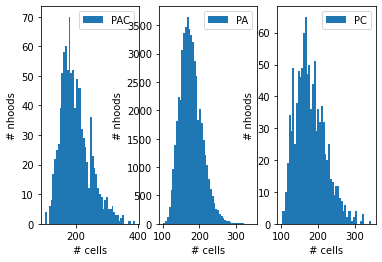

In [149]:
with rc_context({'figure.figsize':[10,3]}):
    plt.subplot(1,3,1);
    _plot_nhood_sizes(pac_design_adata, label='PAC');
    plt.legend()
    plt.subplot(1,3,2);
    _plot_nhood_sizes(pa_design_adata, label='PA');
    plt.legend()
    plt.subplot(1,3,3);
    _plot_nhood_sizes(pc_design_adata, label='PC');
    plt.legend()

### Store nhood confidence

In [169]:
pa_design_unc =pd.read_csv(gdrive_dir + 'uncertainty.PA_design.csv', index_col=0)
pac_design_unc=pd.read_csv(gdrive_dir + 'uncertainty.PAC_design.csv', index_col=0)
pc_design_unc =pd.read_csv(gdrive_dir + 'uncertainty.PC_design.csv', index_col=0)

In [180]:
pac_design_adata.obs['pred_unc'] = pac_design_unc.pred_unc
pa_design_adata.obs['pred_unc'] = pa_design_unc.pred_unc
pc_design_adata.obs['pred_unc'] = pc_design_unc.pred_unc

In [181]:
## Convert to confidence
pac_design_adata.obs['conf_score'] = 1 - pac_design_adata.obs['pred_unc']
pa_design_adata.obs['conf_score'] = 1 - pa_design_adata.obs['pred_unc']
pc_design_adata.obs['conf_score'] = 1 - pc_design_adata.obs['pred_unc']

In [182]:
diff2atlas.nhood_confidence(pac_design_adata, confidence_col='conf_score', sample_col='sample_id', impute_missing=False)
diff2atlas.nhood_confidence(pa_design_adata, confidence_col='conf_score', sample_col='sample_id', impute_missing=False)
diff2atlas.nhood_confidence(pc_design_adata, confidence_col='conf_score', sample_col='sample_id', impute_missing=False)

### Annotate neighbourhoods
Using labels from control samples

In [192]:
milopy.utils.annotate_nhoods(pac_design_adata[pac_design_adata.obs['dataset_group'] == 'ctrl'], 'cell_type')
milopy.utils.annotate_nhoods(pa_design_adata[pa_design_adata.obs['dataset_group'] == 'atlas'], 'cell_type')
milopy.utils.annotate_nhoods(pc_design_adata[pc_design_adata.obs['dataset_group'] == 'ctrl'], 'cell_type')

... storing 'nhood_annotation' as categorical


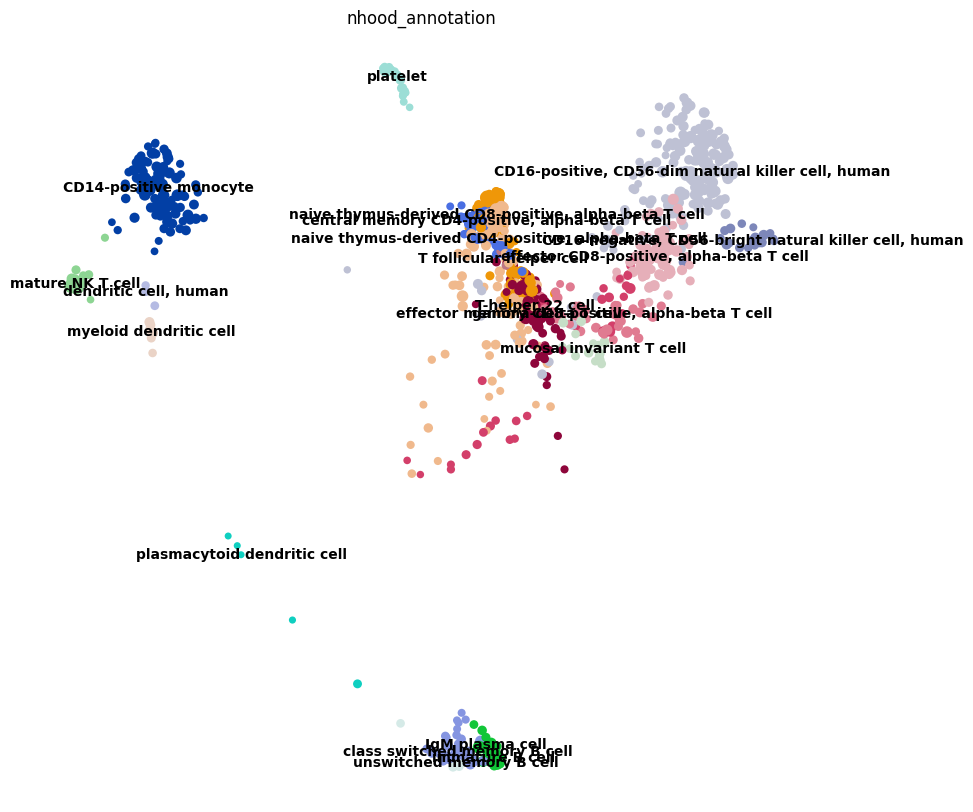

... storing 'nhood_annotation' as categorical


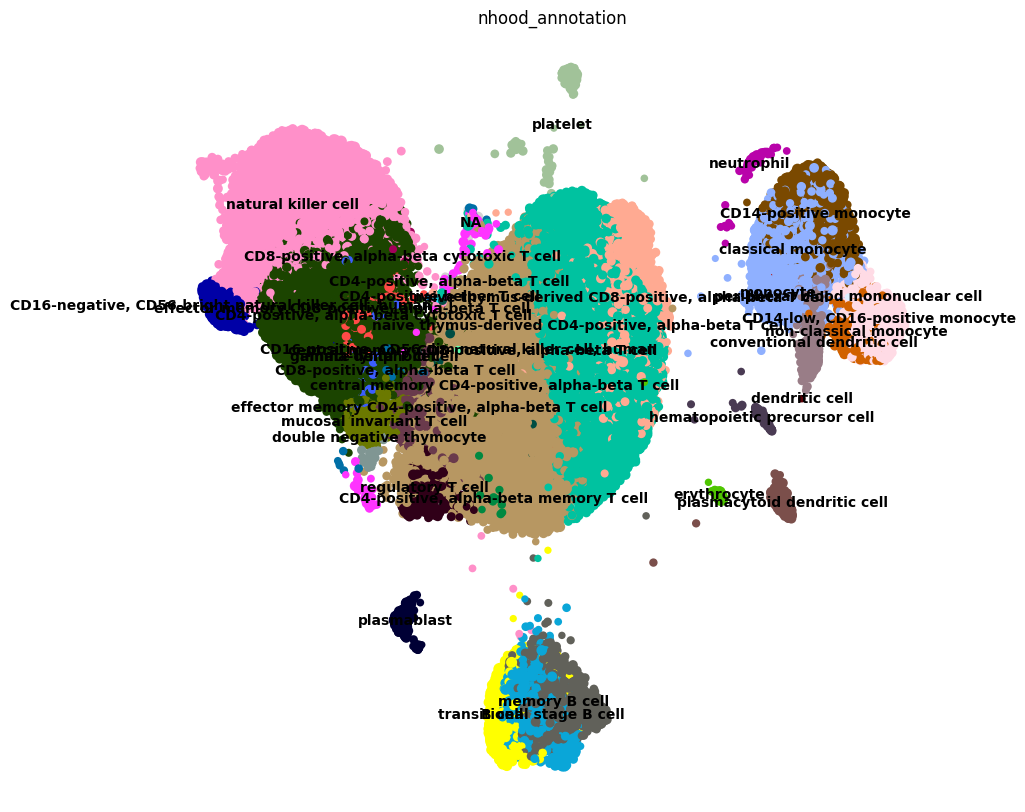

... storing 'nhood_annotation' as categorical


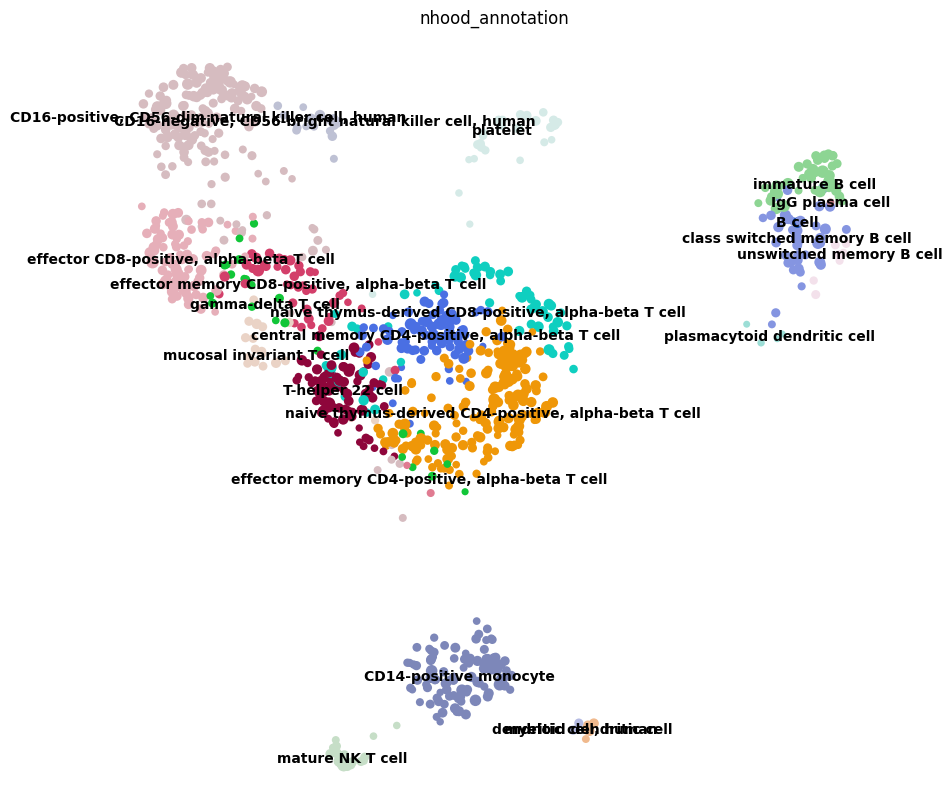

In [193]:
with rc_context({'figure.figsize':[10,10]}):
    diff2atlas.plotting.plot_nhood_graph(pac_design_adata, min_size=1, color='nhood_annotation', legend_loc='on data')
    diff2atlas.plotting.plot_nhood_graph(pa_design_adata, min_size=1, color='nhood_annotation', legend_loc='on data')
    diff2atlas.plotting.plot_nhood_graph(pc_design_adata, min_size=1, color='nhood_annotation', legend_loc='on data')

### Compute DA logFC per neighbourhood

In [194]:
pac_design_adata.obs['is_query'] = pac_design_adata.obs['dataset_group'] == 'query'
pc_design_adata.obs['is_query'] = pc_design_adata.obs['dataset_group'] == 'query'
pa_design_adata.obs['is_query'] = pa_design_adata.obs['dataset_group'] == 'query'

In [195]:
milopy.core.DA_nhoods(pac_design_adata, design='~ is_query')
milopy.core.DA_nhoods(pc_design_adata, design='~ is_query')
milopy.core.DA_nhoods(pa_design_adata, design='~ is_query')

In [202]:
pac_design_adata.uns['nhood_adata']

AnnData object with n_obs × n_vars = 1025 × 30
    obs: 'index_cell', 'kth_distance', 'nhood_annotation', 'nhood_annotation_frac', 'Nhood_size', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR'
    var: 'is_query', 'sample_id'
    uns: 'sample_col', 'nhoods_key', 'annotation_labels', 'nhood'
    obsm: 'frac_annotation', 'X_nhood_graph'
    layers: 'confidence'
    obsp: 'nhood_connectivities'

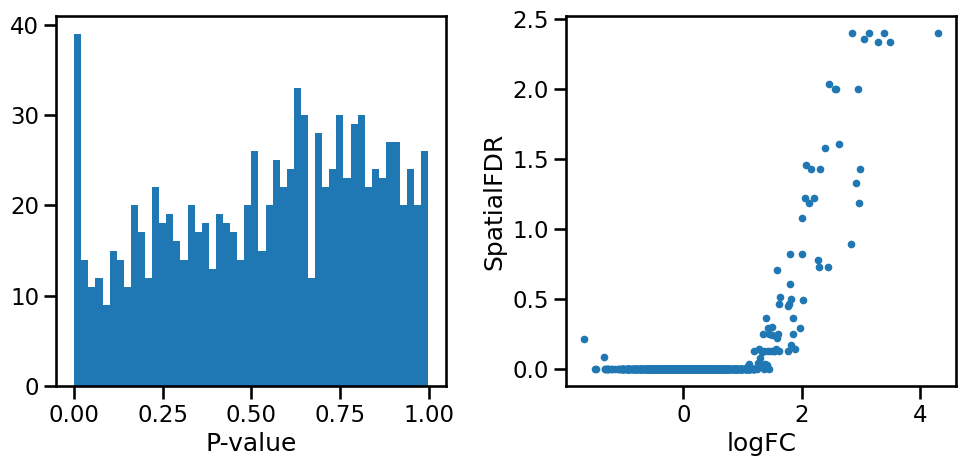

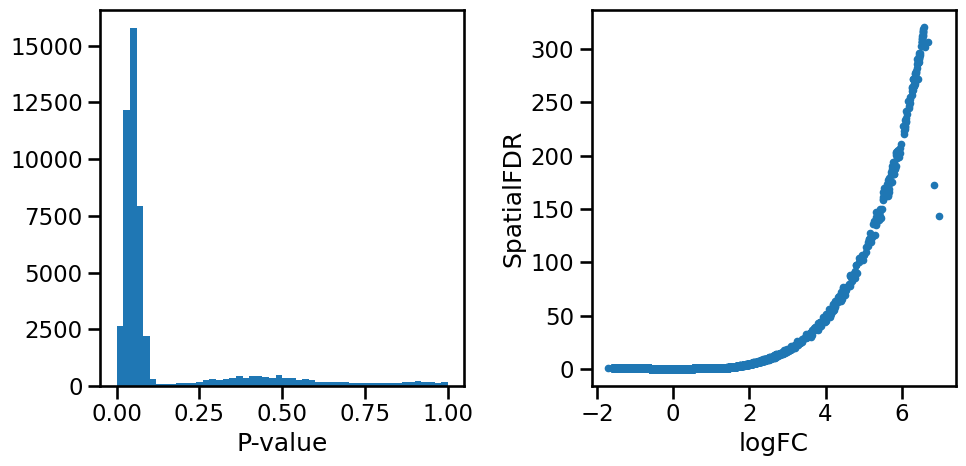

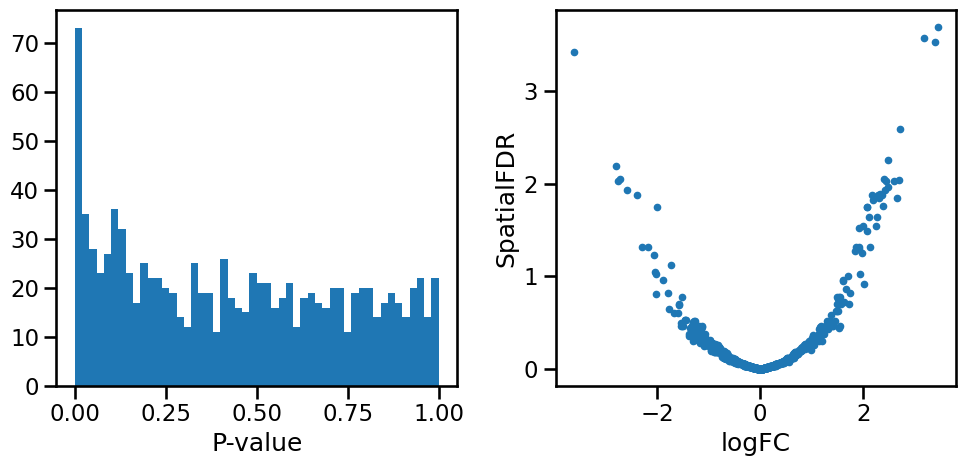

In [204]:
def plot_DA_checks(pac_design_adata):
    lfc = get_nhood_adata(pac_design_adata).obs['logFC']
    FDR_perc = -np.log10(get_nhood_adata(pac_design_adata).obs['SpatialFDR'])
    pvals = get_nhood_adata(pac_design_adata).obs['PValue']
    plt.subplot(1,2,1);
    plt.hist(pvals, bins=50);
    plt.xlabel('P-value');
    plt.subplot(1,2,2);
    plt.plot(lfc, FDR_perc, '.');
    plt.ylabel('SpatialFDR');
    plt.xlabel('logFC');
    plt.tight_layout();
    plt.show()

sns.set_context('talk');
with rc_context({'figure.figsize':[10,5]}):
    plot_DA_checks(pac_design_adata)
    plot_DA_checks(pa_design_adata)
    plot_DA_checks(pc_design_adata)

In [205]:
milopy.utils.build_nhood_graph(pac_design_adata)
milopy.utils.build_nhood_graph(pc_design_adata)
milopy.utils.build_nhood_graph(pa_design_adata)

... storing 'nhood_annotation' as categorical


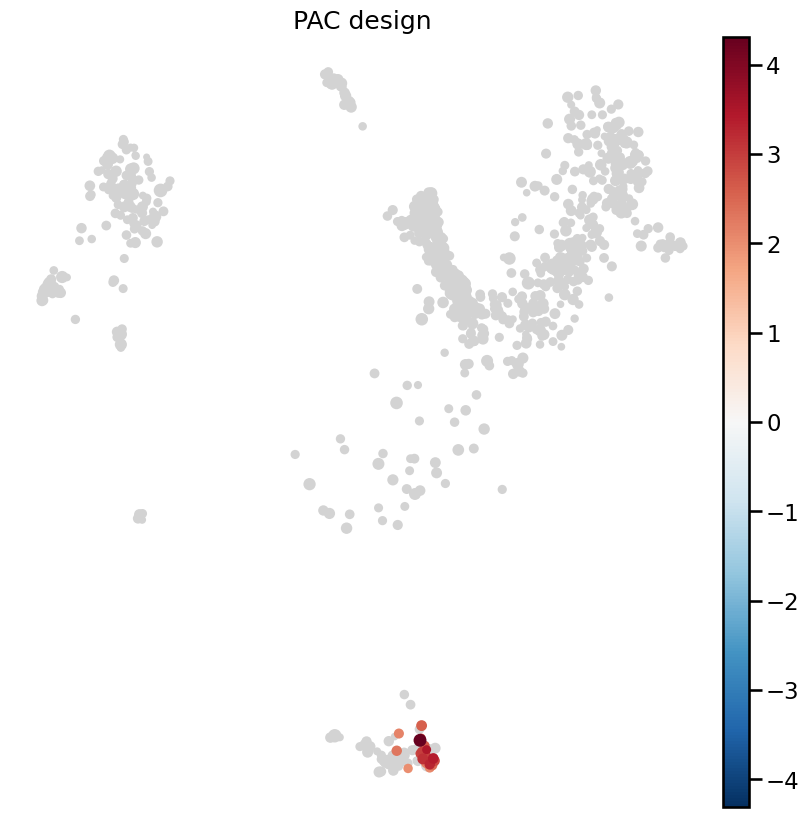

... storing 'nhood_annotation' as categorical


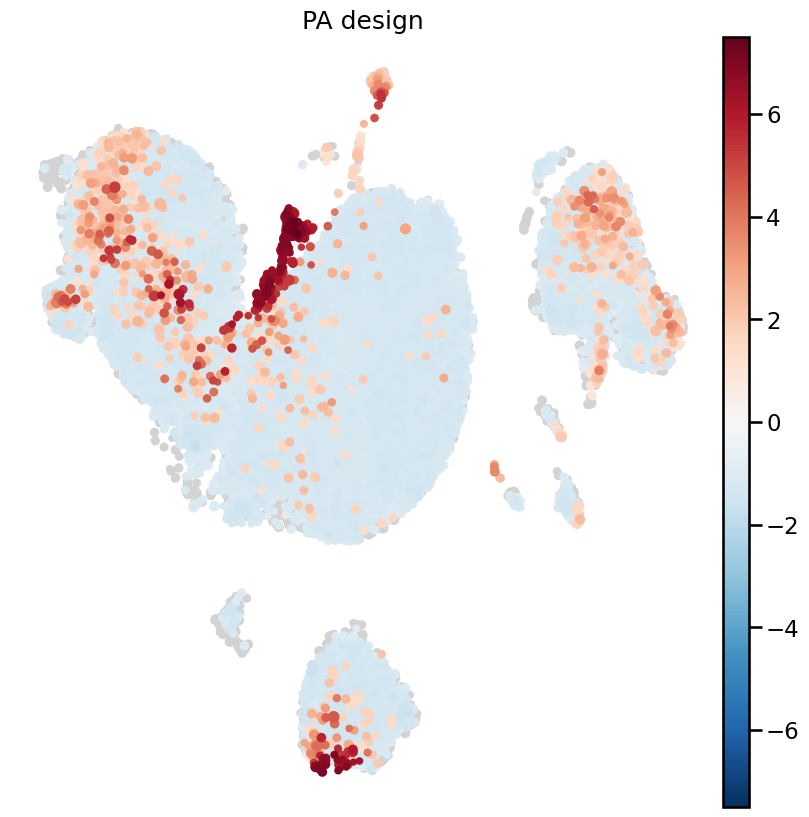

... storing 'nhood_annotation' as categorical


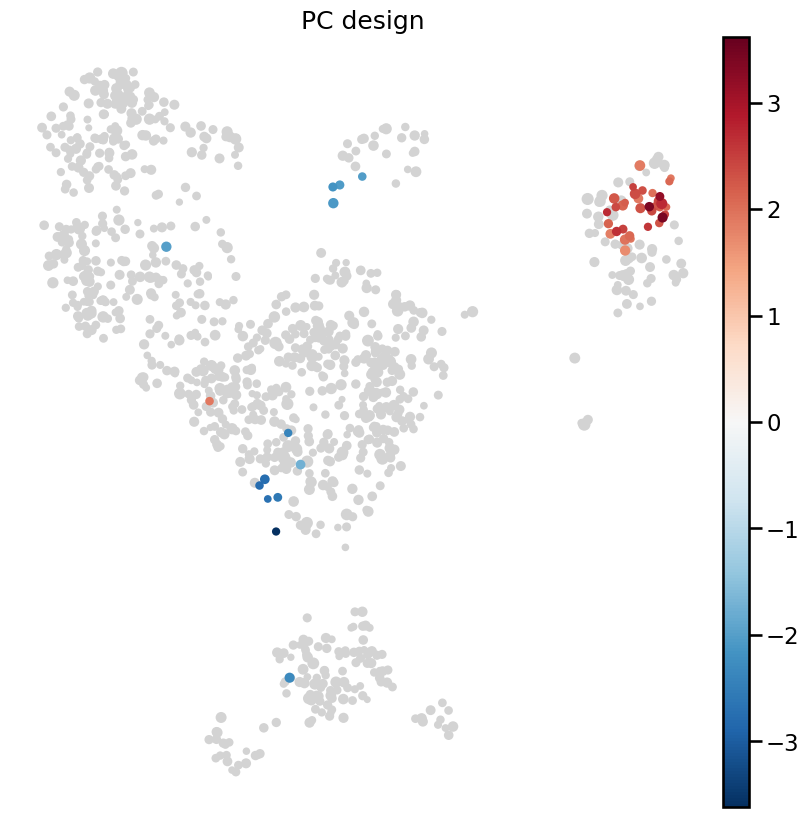

In [206]:
with rc_context({'figure.figsize':[10,10]}):
    milopy.plot.plot_nhood_graph(pac_design_adata, min_size=1, title='PAC design')
    milopy.plot.plot_nhood_graph(pa_design_adata, min_size=1, title='PA design')
    milopy.plot.plot_nhood_graph(pc_design_adata, min_size=1, title='PC design')


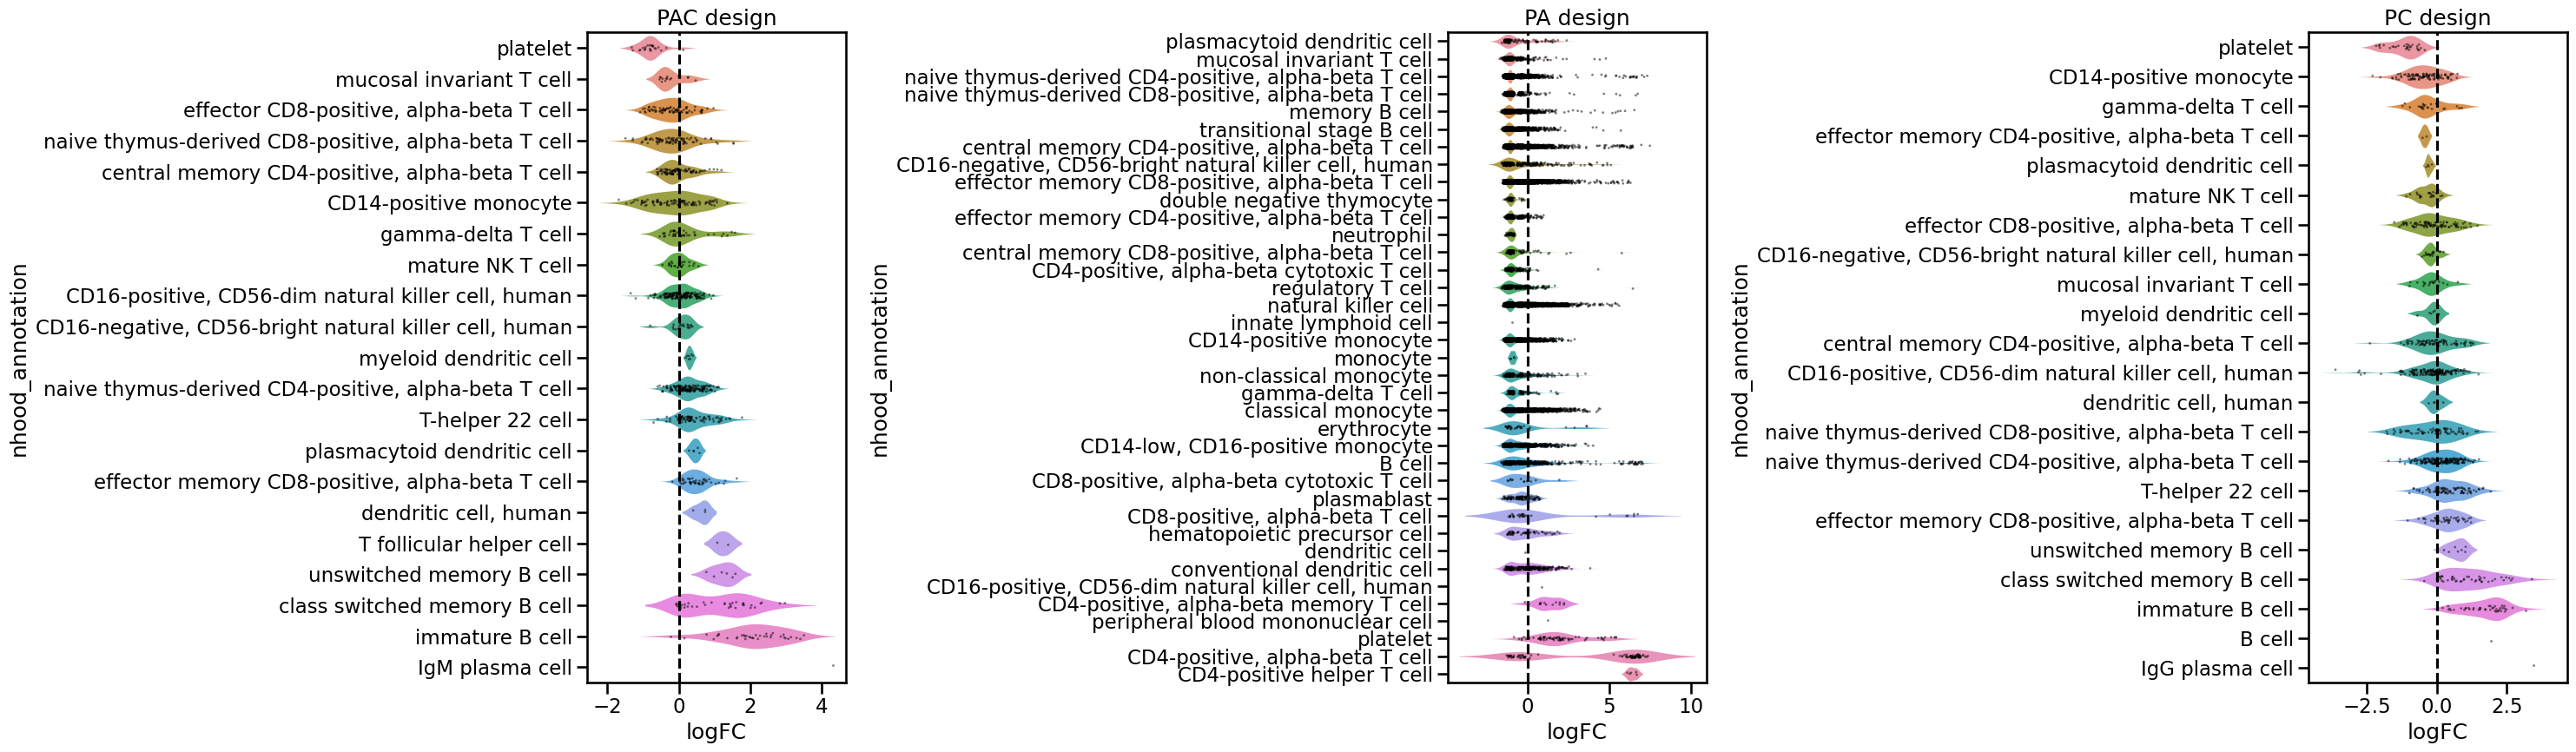

In [208]:
with rc_context({'figure.figsize':[30,9]}):
    plt.subplot(1,3,1);
    milopy.plot.plot_DA_beeswarm(pac_design_adata);
    plt.title('PAC design');
    plt.subplot(1,3,2);
    milopy.plot.plot_DA_beeswarm(pa_design_adata);
    plt.title('PA design');
    plt.subplot(1,3,3);
    milopy.plot.plot_DA_beeswarm(pc_design_adata);
    plt.title('PC design');
    plt.tight_layout()

### Confidence metrics

In [470]:
## Compute mean confidence for query cells 
# get_nhood_adata(pac_design_adata)
def get_mean_confidence_x_nhood(adata, obs_names, confidence_col = 'conf_score'):
    '''
    Compute average confidence per neighbourhood using a subset of cells
    '''
    nhood_mat = adata[obs_names].obsm['nhoods']
    mean_conf_nhoods = nhood_mat.T.dot(
            scipy.sparse.csr_matrix(adata.obs.loc[obs_names, confidence_col]).T)
    mean_conf_nhoods = mean_conf_nhoods.toarray()/np.array(nhood_mat.T.sum(1))
    mean_conf_nhoods = np.nan_to_num(mean_conf_nhoods, 0) ## zero confidence where we have no cells
    return(mean_conf_nhoods)


get_nhood_adata(pac_design_adata).obs['conf_score_KO'] = get_mean_confidence_x_nhood(
    pac_design_adata, obs_names = pac_design_adata.obs_names[pac_design_adata.obs['dataset_group'] == 'query'])
get_nhood_adata(pa_design_adata).obs['conf_score_KO'] = get_mean_confidence_x_nhood(
    pa_design_adata, obs_names = pa_design_adata.obs_names[pa_design_adata.obs['dataset_group'] == 'query'])
get_nhood_adata(pc_design_adata).obs['conf_score_KO'] = get_mean_confidence_x_nhood(
    pc_design_adata, obs_names = pc_design_adata.obs_names[pc_design_adata.obs['dataset_group'] == 'query'])

In [471]:
get_nhood_adata(pac_design_adata).obs['conf_score_ctrl'] = get_mean_confidence_x_nhood(
    pac_design_adata, obs_names = pac_design_adata.obs_names[pac_design_adata.obs['dataset_group'] != 'query'])
get_nhood_adata(pa_design_adata).obs['conf_score_ctrl'] = get_mean_confidence_x_nhood(
    pa_design_adata, obs_names = pa_design_adata.obs_names[pa_design_adata.obs['dataset_group'] != 'query'])
get_nhood_adata(pc_design_adata).obs['conf_score_ctrl'] = get_mean_confidence_x_nhood(
    pc_design_adata, obs_names = pc_design_adata.obs_names[pc_design_adata.obs['dataset_group'] != 'query'])

In [333]:
pa_nhood_obs = get_nhood_adata(pa_design_adata).obs.copy()
pac_nhood_obs = get_nhood_adata(pac_design_adata).obs.copy()
pc_nhood_obs = get_nhood_adata(pc_design_adata).obs.copy()

pac_nhood_obs['design'] = 'PAC'
pa_nhood_obs['design'] = 'PA'
pc_nhood_obs['design'] = 'PC'

nhood_obs_df = pd.concat([pac_nhood_obs, pc_nhood_obs, pa_nhood_obs])

In [334]:
%%R -i nhood_obs_df
dim(nhood_obs_df)

[1] 53461    20


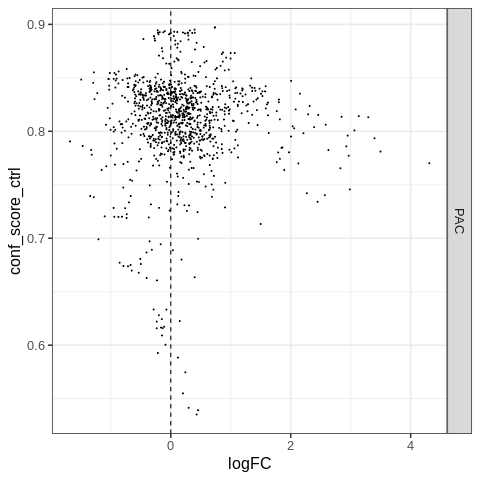

In [343]:
%%R
nhood_obs_df %>%
filter(design=='PAC') %>%
ggplot(aes(logFC, conf_score_ctrl)) +
geom_point(size=0.3) +
geom_point(data=. %>% filter(nhood_annotation=='Endothelium'), color='red') +
facet_grid(design~.) +
geom_vline(xintercept=0, linetype=2) +
theme_bw(base_size=16)

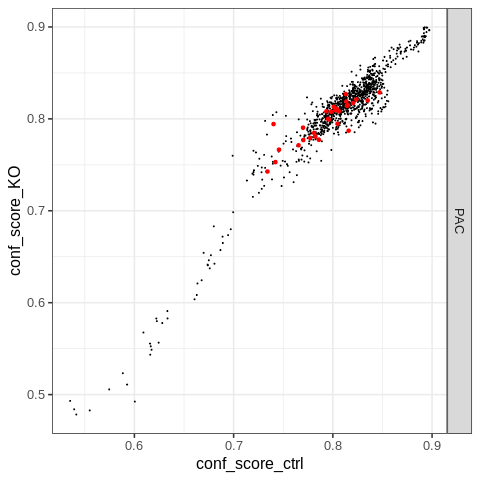

In [340]:
%%R
nhood_obs_df %>%
filter(design=='PAC') %>%
ggplot(aes(conf_score_ctrl, conf_score_KO)) +
geom_point(size=0.3) +
geom_point(data=. %>% filter(logFC > 2), color='red') +
facet_grid(design~.) +
theme_bw(base_size=16)

In [415]:
## Differential uncertainty
pac_design_adata.obs['is_query'] = pac_design_adata.obs['is_query'].astype('int').astype('str')
pac_design_adata.uns['nhood_adata'].var['is_query'] = pac_design_adata.uns['nhood_adata'].var['is_query'].astype('int').astype('str')
diff2atlas.nhood_confidence(pac_design_adata, confidence_col='conf_score', sample_col='sample_id', impute_missing=False, min_cells=3)
diff2atlas.make_design(pac_design_adata, categorical_covariates=['dataset_group', 'is_query'])

In [416]:
diff2atlas.highly_variable_nhoods(pac_design_adata)

In [413]:
import diff2atlas

In [460]:
diff2atlas.test_confidence(pac_design_adata, test_covariate='is_query', method='OLS', ref_level='1', use_highly_variable=True)

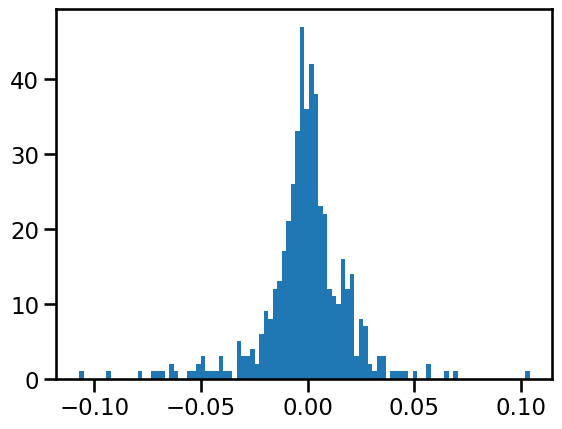

In [461]:
plt.hist(get_nhood_adata(pac_design_adata).obs['confidence_test_statistic'], bins=100);

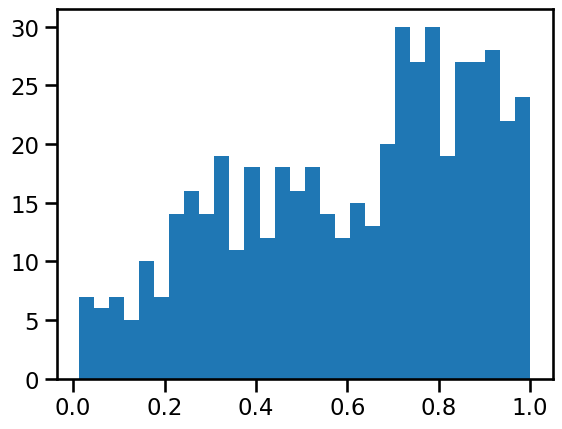

In [463]:
plt.hist(get_nhood_adata(pac_design_adata).obs['confidence_test_pvals'], bins=30);

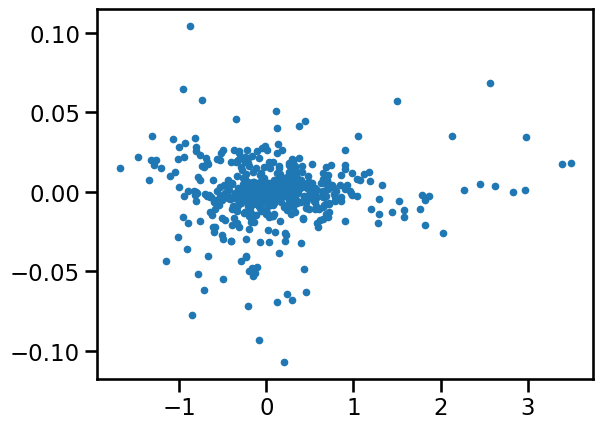

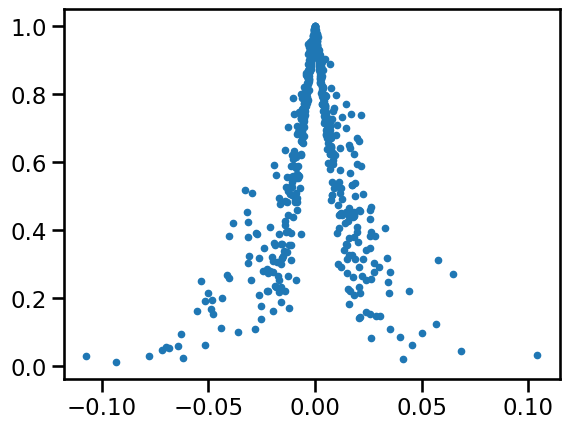

In [464]:
plt.plot(get_nhood_adata(pac_design_adata).obs['logFC'], get_nhood_adata(pac_design_adata).obs['confidence_test_statistic'], '.');
plt.show()
plt.plot(get_nhood_adata(pac_design_adata).obs['confidence_test_statistic'], get_nhood_adata(pac_design_adata).obs['confidence_test_pvals'], '.')

... storing 'nhood_annotation' as categorical


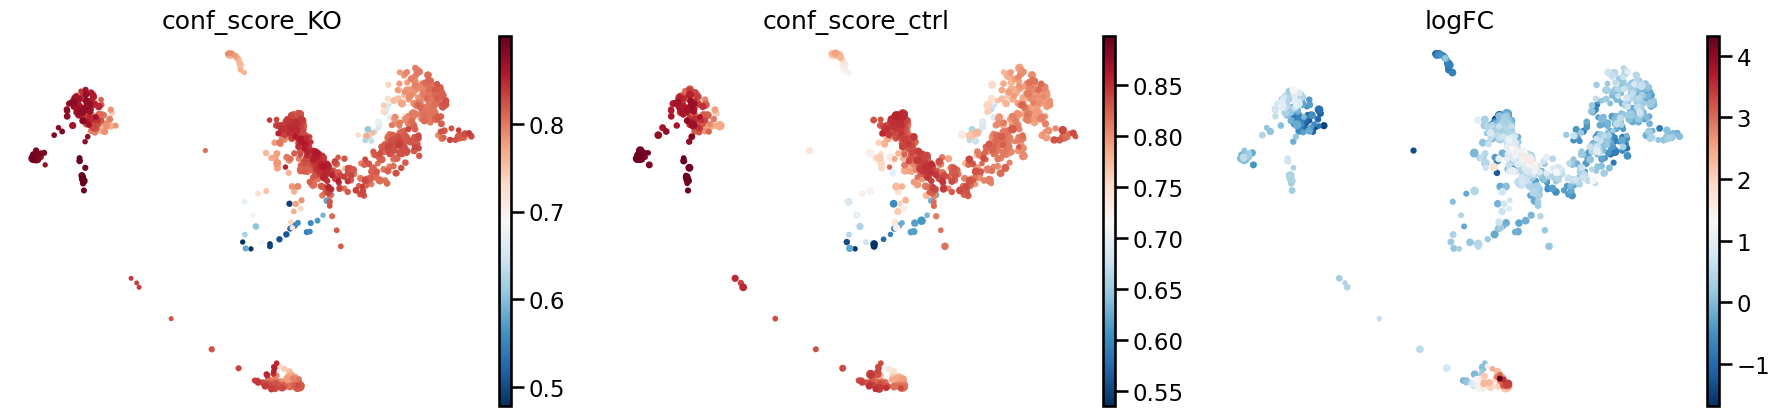

In [475]:
diff2atlas.plotting.plot_nhood_graph(pac_design_adata, min_size=0.5, color=['conf_score_KO', 'conf_score_ctrl', 'logFC'], cmap='RdBu_r')

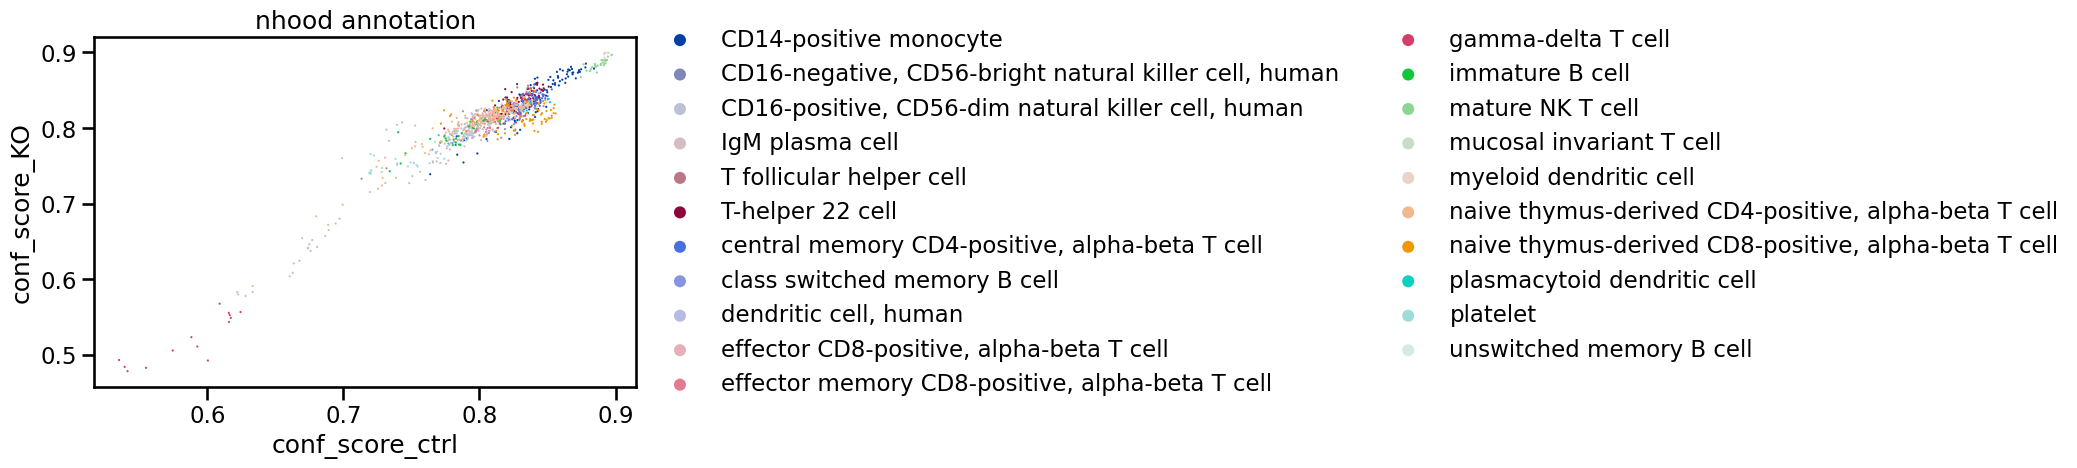

In [483]:
sc.pl.scatter(get_nhood_adata(pac_design_adata),  'conf_score_ctrl','conf_score_KO', color='nhood_annotation',size=10)

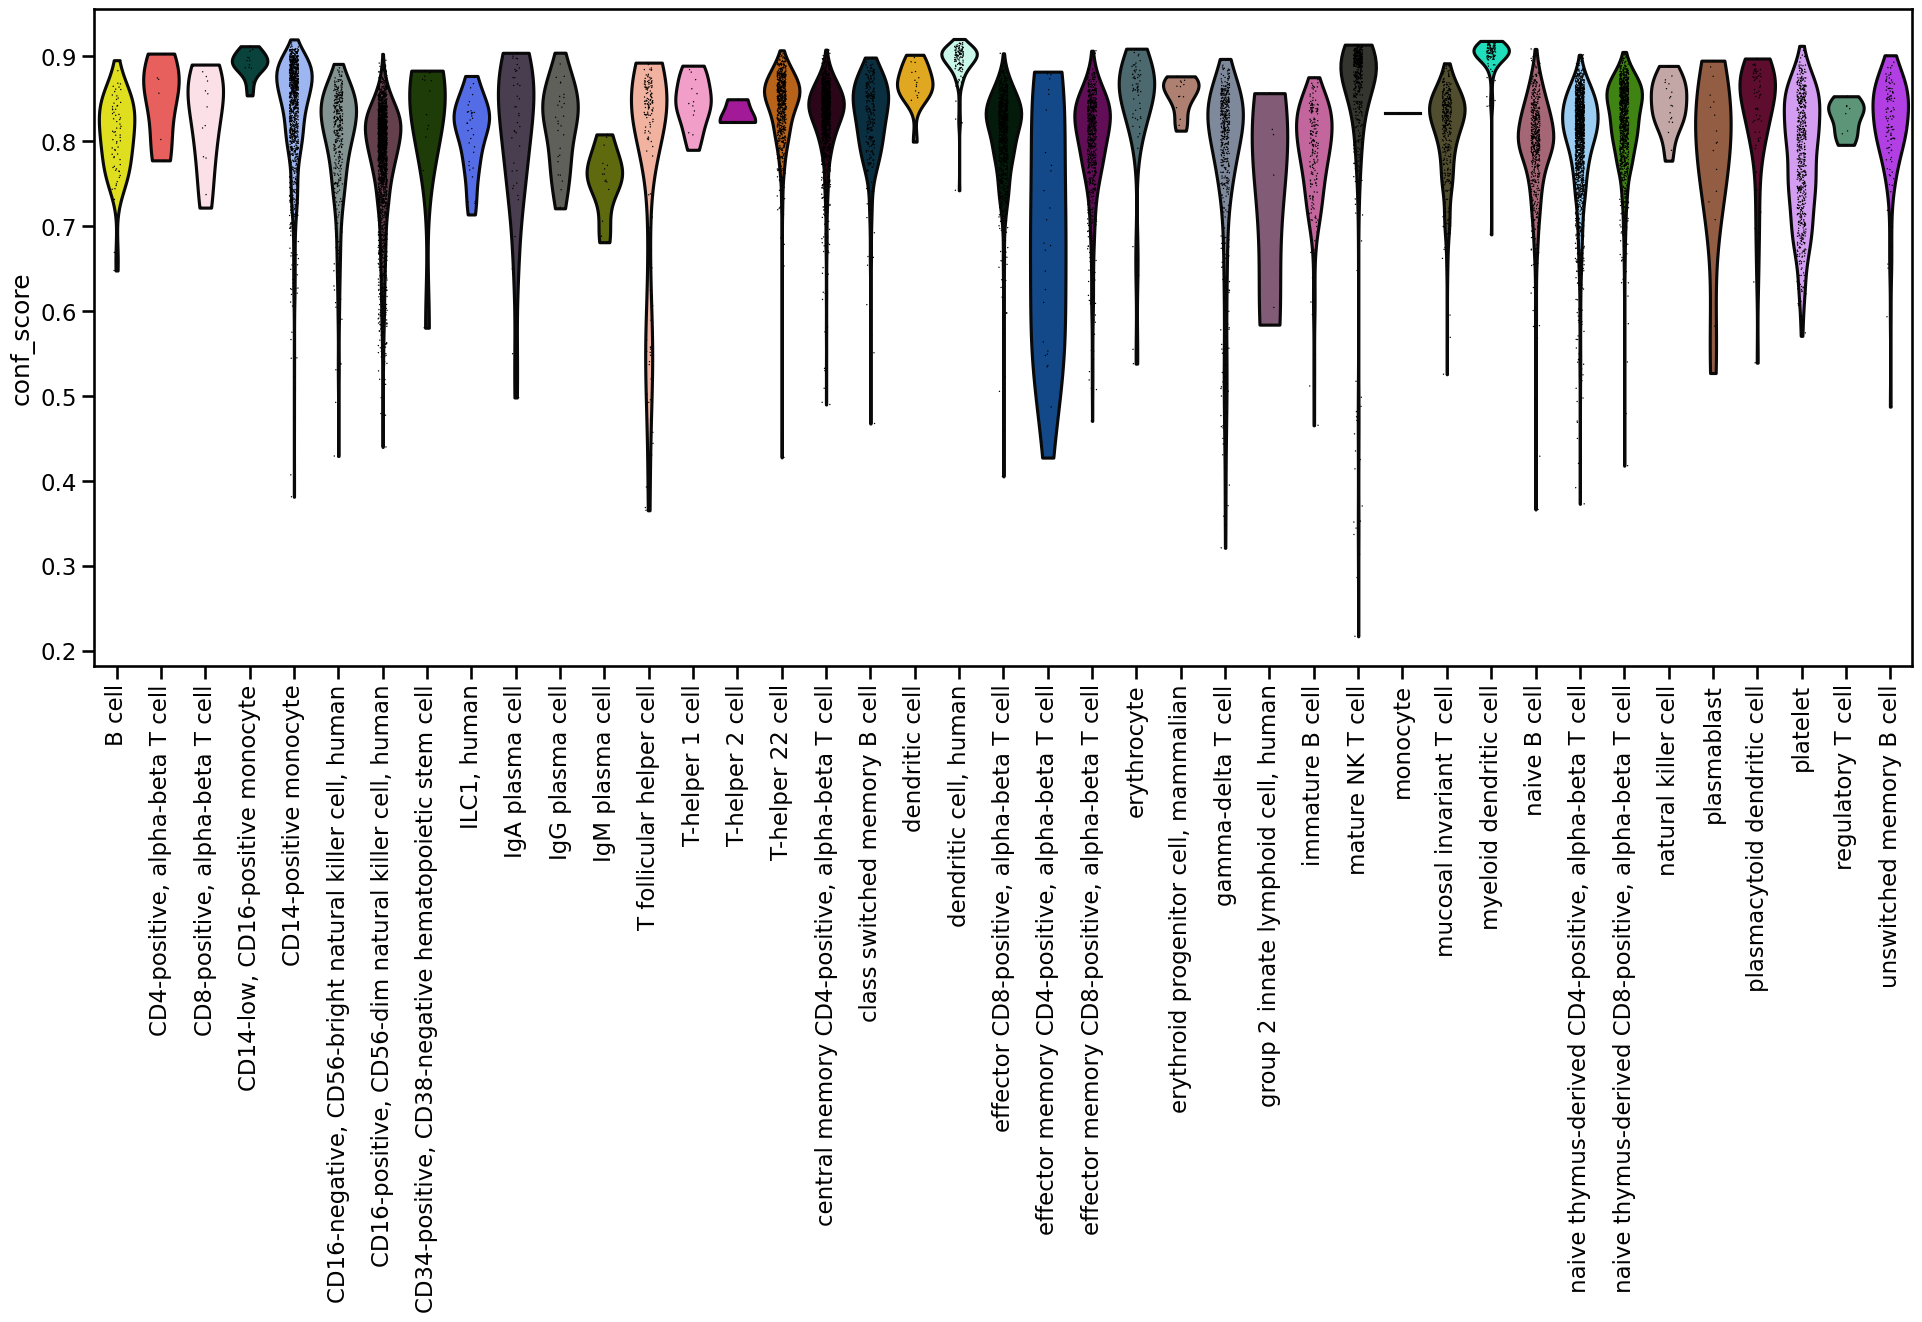

In [443]:
with rc_context({'figure.figsize':[18,9]}):
    sc.pl.violin(pac_design_adata, 'conf_score',groupby='cell_type', rotation=90)

In [444]:
obs = get_nhood_adata(pac_design_adata).obs_names[pac_design_adata[pac_design_adata.obs['cell_type'] == 'naive B cell'].obsm['nhoods'].toarray().sum(0) > 10]

In [467]:
obs = get_nhood_adata(pac_design_adata).obs_names[get_nhood_adata(pac_design_adata).obs['SpatialFDR'] < 0.1]
obs

Index(['8', '11', '16', '17', '26', '29', '42', '52', '113', '204', '245',
       '248', '252', '254', '260', '261', '305', '390', '437', '470', '534',
       '546', '911'],
      dtype='object')

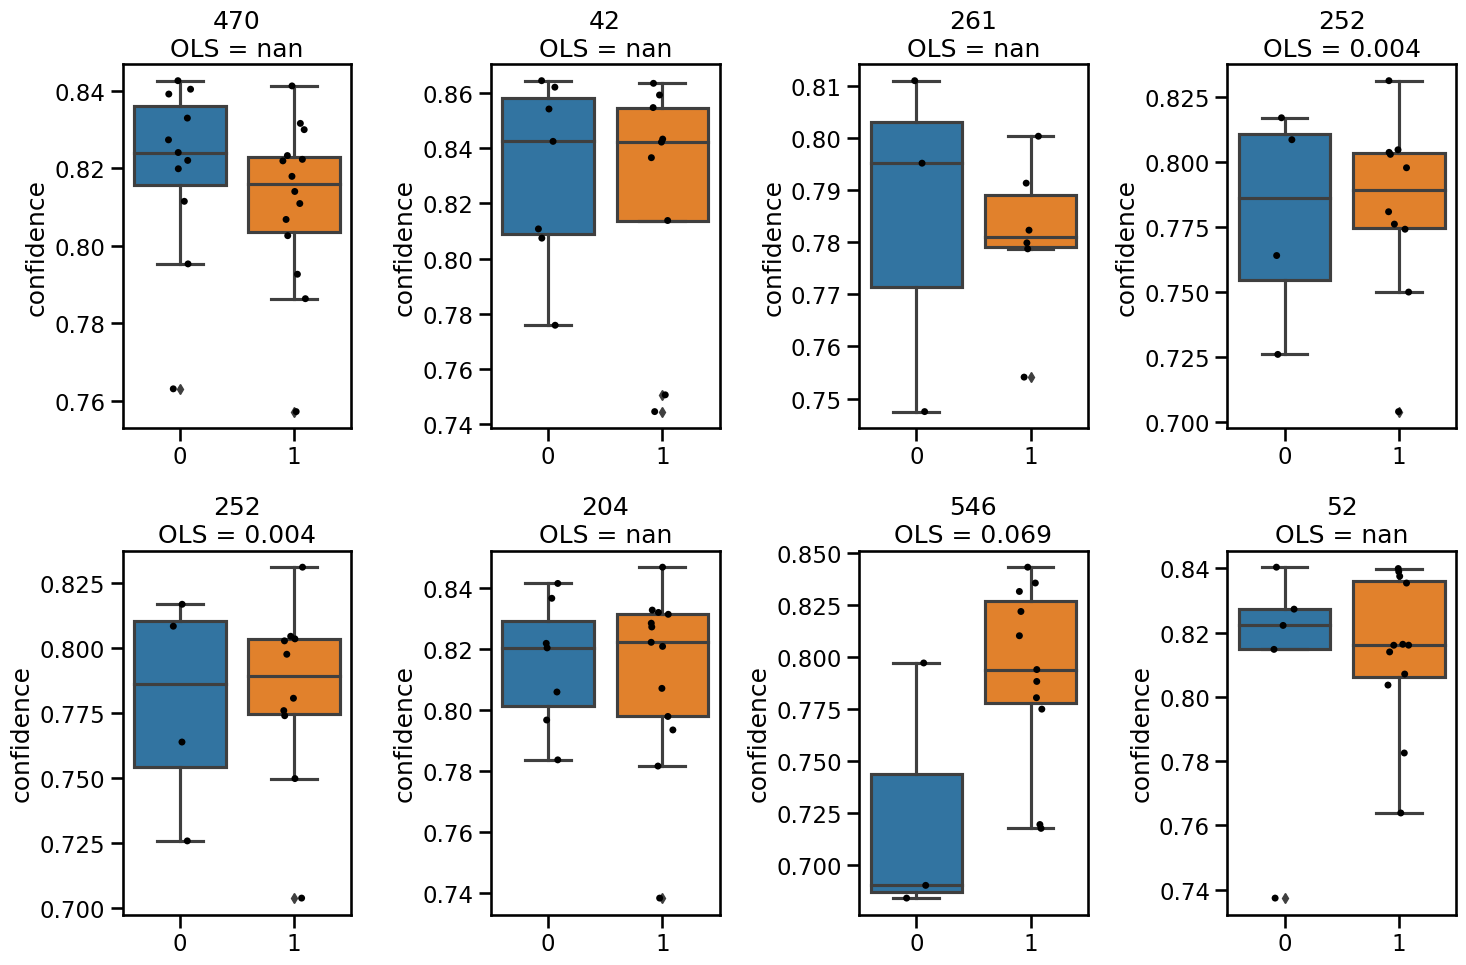

In [468]:
with rc_context({'figure.figsize': (15, 10)}):
    diff2atlas.plotting.plot_nhood_confidence_boxplot(pac_design_adata, obs_names = np.random.choice(obs, 8), n_cols=4)

1. Mean confidence is associated to total number of cells in neighbourhood

In [431]:
x_conf = get_nhood_adata(pac_design_adata)[:,10].layers['confidence'].toarray().flatten()
x_counts = get_nhood_adata(pac_design_adata)[:,10].X.toarray().flatten()
x_conf

array([0.83405667, 0.81306127, 0.84677305, ...,        nan, 0.84218342,
       0.81988541])

Text(0, 0.5, 'mean confidence')

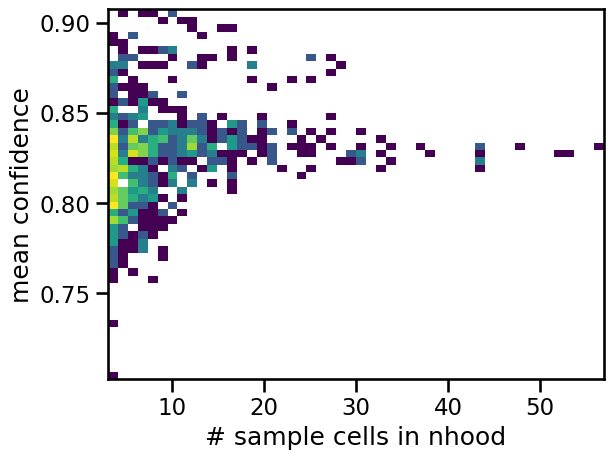

In [432]:
import matplotlib
plt.hist2d(x_counts[~np.isnan(x_conf)], x_conf[~np.isnan(x_conf)], norm=matplotlib.colors.LogNorm(), bins=50);
plt.xlabel("# sample cells in nhood");
plt.ylabel('mean confidence')

In [434]:
x_conf = get_nhood_adata(pac_design_adata)[:,10].layers['confidence'].toarray().flatten()
x_counts = get_nhood_adata(pac_design_adata)[:,10].X.toarray().flatten()
nhood_size = np.array(pac_design_adata.obsm['nhoods'].sum(0)).flatten()

Text(0.5, 0, 'tot cells in nhood')

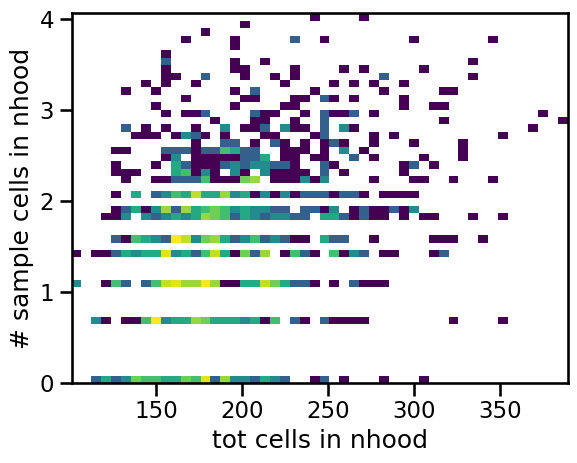

In [435]:
import matplotlib
plt.hist2d(nhood_size,np.log(x_counts+1), norm=matplotlib.colors.LogNorm(), bins=50);
plt.ylabel("# sample cells in nhood");
plt.xlabel('tot cells in nhood')

Text(0, 0.5, 'mean confidence')

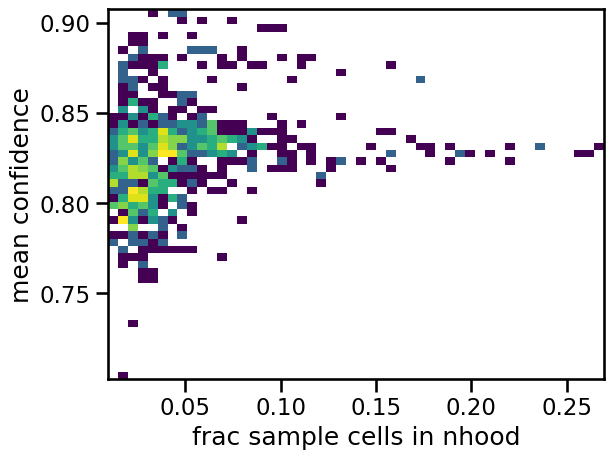

In [436]:
import matplotlib
plt.hist2d((x_counts/nhood_size)[~np.isnan(x_conf)], x_conf[~np.isnan(x_conf)], norm=matplotlib.colors.LogNorm(), bins=50);
plt.xlabel("frac sample cells in nhood");
plt.ylabel('mean confidence')

In [447]:
order_samples = get_nhood_adata(pac_design_adata)[obs].var['dataset_group'].sort_values()

In [448]:
colnames = (order_samples.index.astype('str') + "_" + order_samples.values.astype('str')).tolist()

<AxesSubplot:>

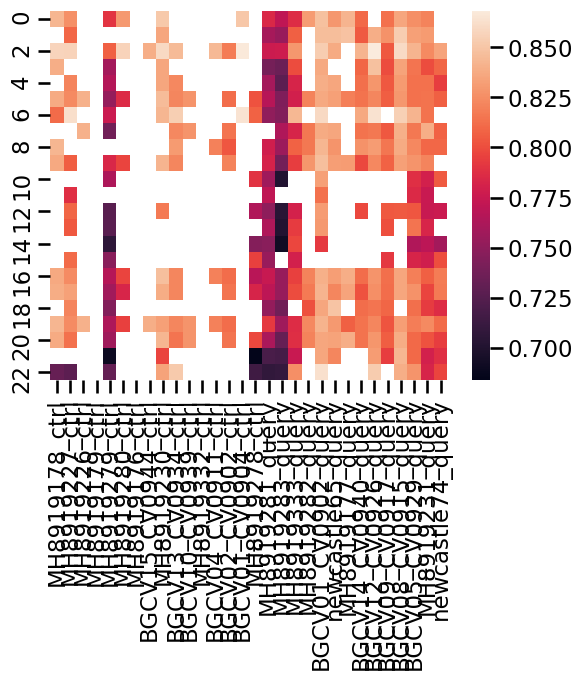

In [449]:
conf_df = pd.DataFrame(get_nhood_adata(pac_design_adata)[obs][:, order_samples.index].layers['confidence'], 
                       columns=colnames)

sns.heatmap(conf_df, xticklabels=True)

In [344]:
pa_nhood_obs = get_nhood_adata(pa_design_adata).obs.copy()
pac_nhood_obs = get_nhood_adata(pac_design_adata).obs.copy()
pc_nhood_obs = get_nhood_adata(pc_design_adata).obs.copy()

pac_nhood_obs['design'] = 'PAC'
pa_nhood_obs['design'] = 'PA'
pc_nhood_obs['design'] = 'PC'

nhood_obs_df = pd.concat([pac_nhood_obs, pc_nhood_obs, pa_nhood_obs])

In [345]:
%%R -i nhood_obs_df
dim(nhood_obs_df)

[1] 53461    20


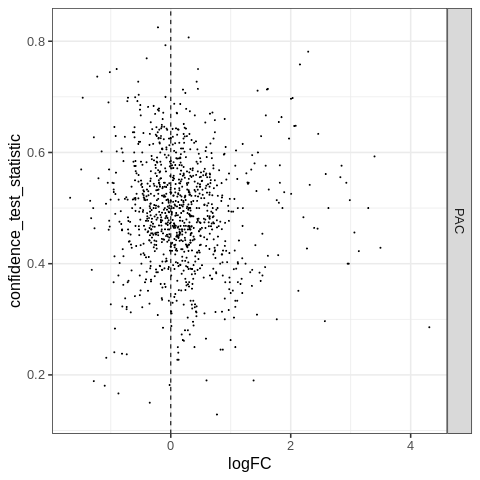

In [346]:
%%R
nhood_obs_df %>%
filter(design=='PAC') %>%
ggplot(aes(logFC, confidence_test_statistic)) +
geom_point(size=0.3) +
geom_point(data=. %>% filter(nhood_annotation=='Endothelium'), color='red') +
facet_grid(design~.) +
geom_vline(xintercept=0, linetype=2) +
theme_bw(base_size=16)

- Finding control cohort by agreement of composiiton: correlation across neighbourhoods/celltypes
- Distances between samples as a weight for testing
- Talk to Leah

- Test using the control in the PA design


In [554]:
pa_design_adata.obs['dataset_id'] = np.where(pa_design_adata.obs['dataset_id'].str.startswith("10_1016_j_cell_2021_02_018"), '10_1016_j_cell_2021_02_018', pa_design_adata.obs['dataset_id'])
milopy.utils.add_covariate_to_nhoods_var(pa_design_adata, ['sex', 'donor_id', 'dataset_id'])
nhood_adata = get_nhood_adata(pa_design_adata).T.copy()

In [555]:
nhood_adata.obs['total_counts'] = nhood_adata.X.toarray().sum(1)

In [556]:
sc.pp.normalize_per_cell(nhood_adata,counts_per_cell_after=10000);
sc.pp.log1p(nhood_adata)

In [572]:
sc.tl.pca(nhood_adata, n_comps=10)

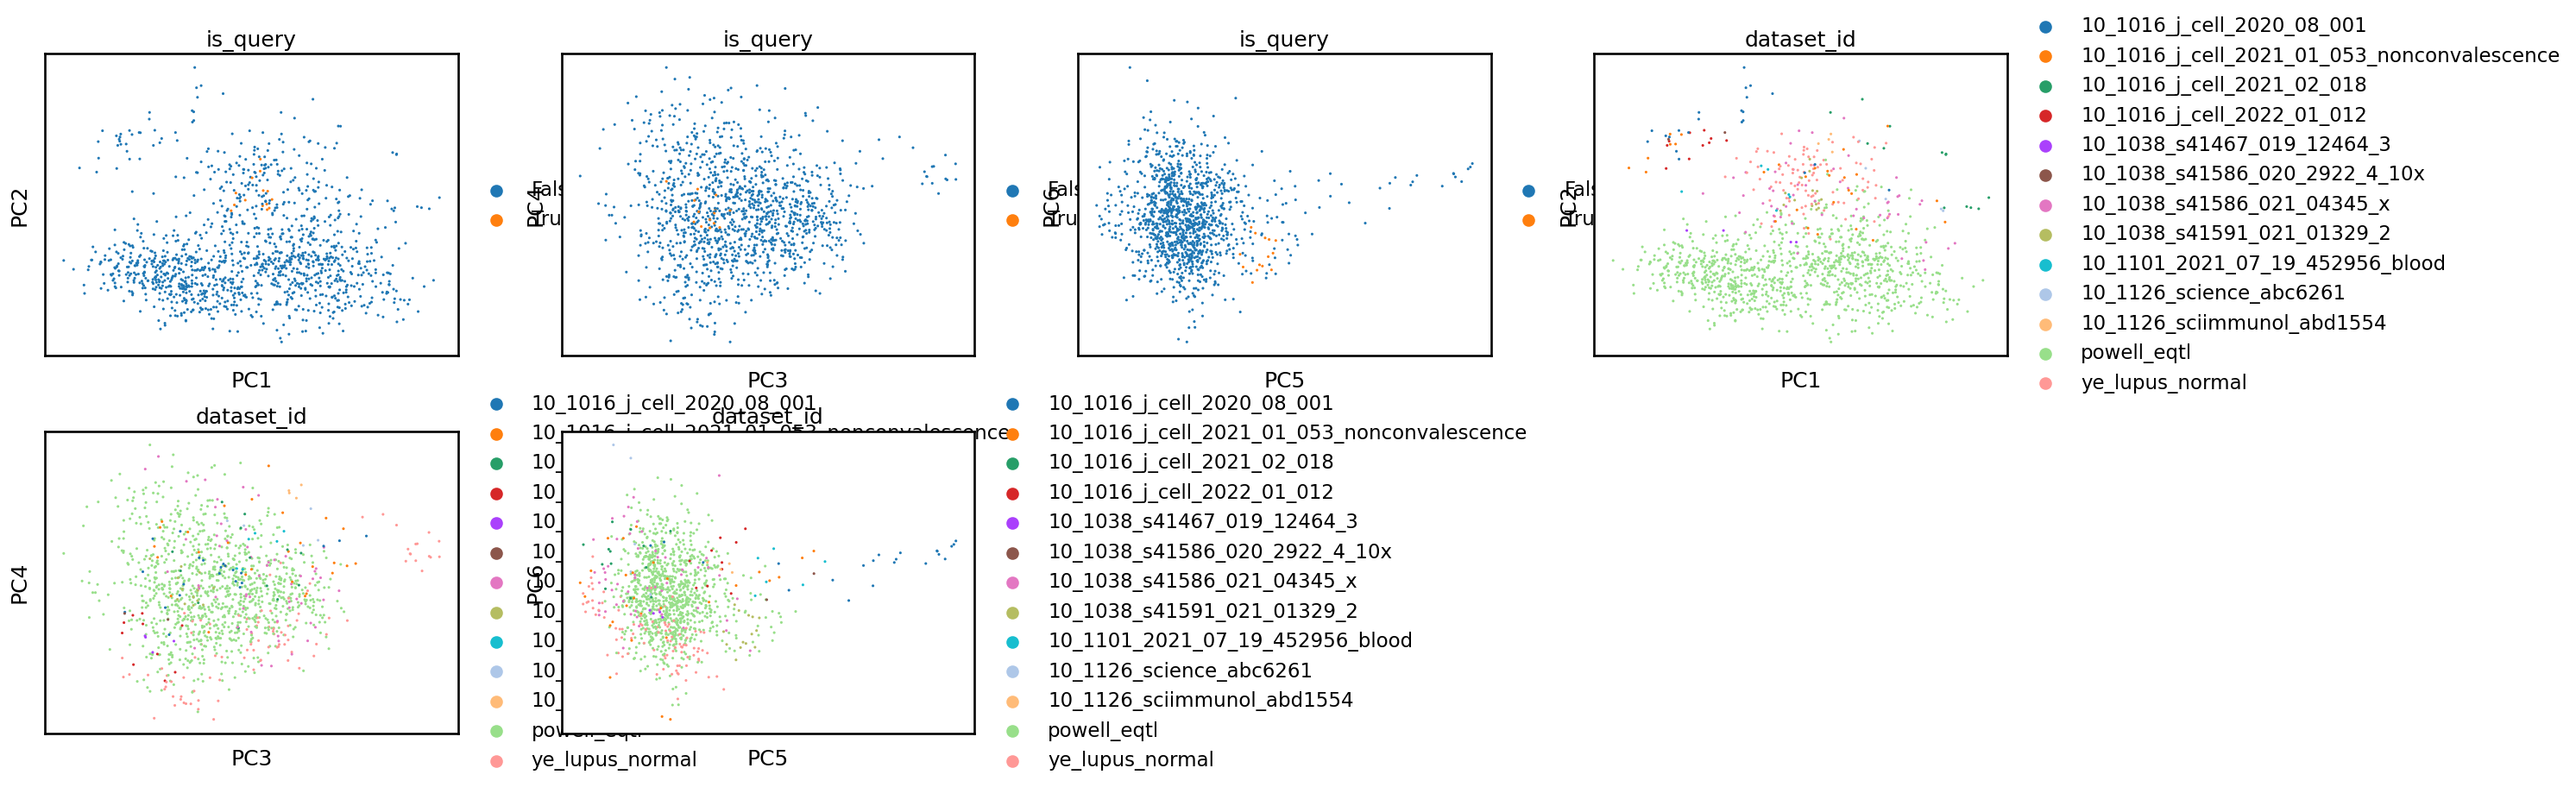

In [573]:
sc.pl.pca(nhood_adata, color=['is_query', 'dataset_id'], size=20, components=['1,2', '3,4', '5,6'])

In [574]:
df = pa_design_adata.obs[['dataset_id', 'sample_id']].drop_duplicates()
df.index = df.sample_id.values

In [575]:
def get_palette(adata, obs_col):
    palette = dict(zip(adata.obs[obs_col].cat.categories, adata.uns[obs_col + '_colors']))
    return(palette)

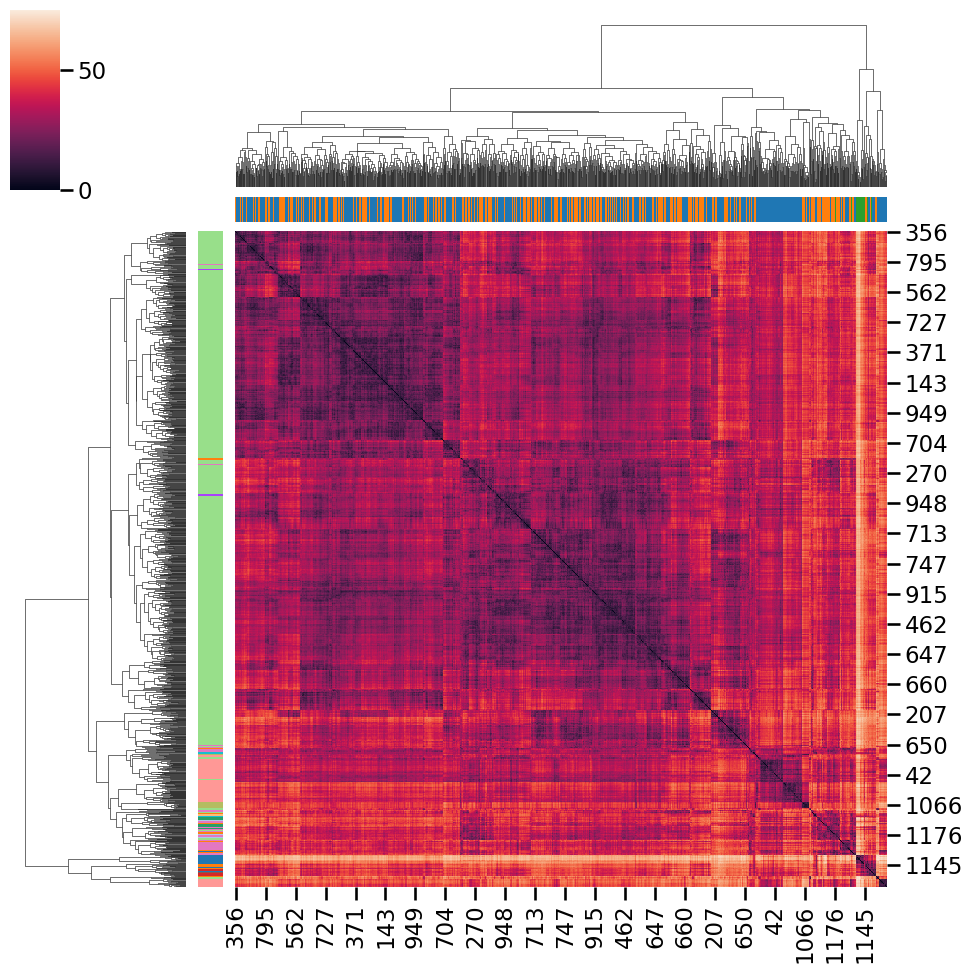

In [578]:
dist_mat = scipy.spatial.distance.cdist(nhood_adata.obsm['X_pca'], nhood_adata.obsm['X_pca'])
sns.clustermap(dist_mat, 
               row_colors=[get_palette(nhood_adata, 'dataset_id')[x] for x in nhood_adata.obs['dataset_id']], 
               col_colors=[get_palette(nhood_adata, 'sex')[x] for x in nhood_adata.obs['sex']]
              )

In [608]:
samples = nhood_adata.obs[nhood_adata.obs.dataset_id == "10_1038_s41591_021_01329_2"].index
dist_mat_self = scipy.spatial.distance.cdist(nhood_adata[samples].obsm['X_pca'], nhood_adata[samples].obsm['X_pca'])
dist_mat_other = scipy.spatial.distance.cdist(nhood_adata[samples].obsm['X_pca'], nhood_adata[~nhood_adata.obs_names.isin(samples)].obsm['X_pca'])
dist_mat.shape

(14, 1239)

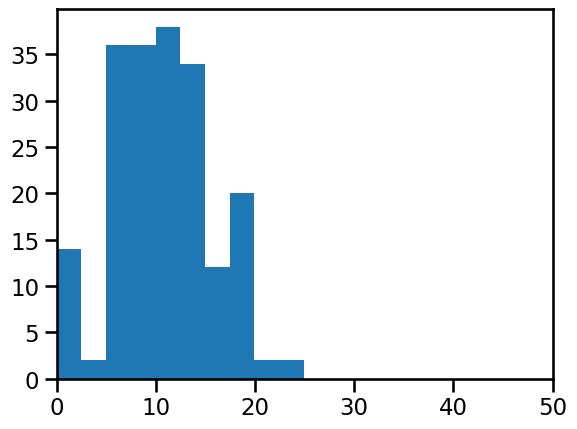

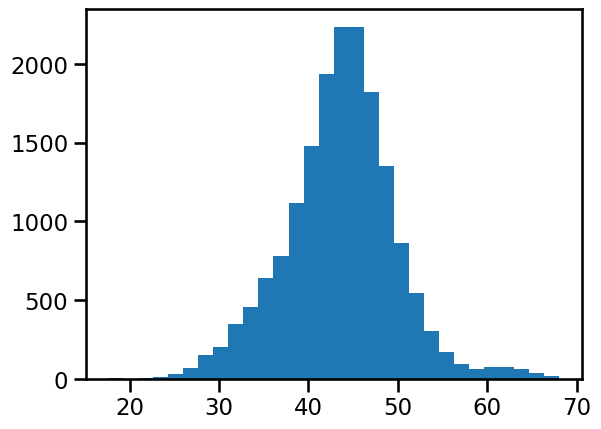

In [620]:
plt.hist(dist_mat_self.flatten(), bins=10);
plt.xlim(0,50);
plt.show();
plt.hist(dist_mat_other.flatten(), bins=30);

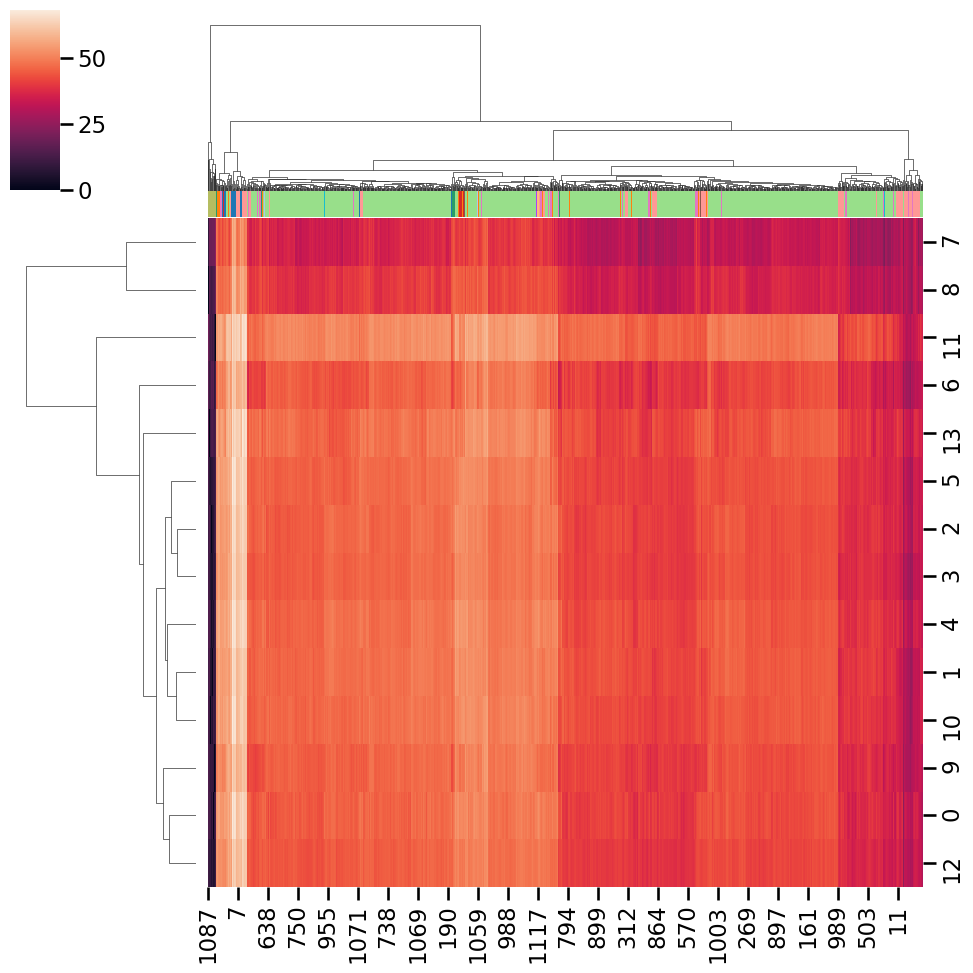

In [607]:
sns.clustermap(dist_mat, 
               col_colors=[get_palette(nhood_adata, 'dataset_id')[x] for x in nhood_adata.obs['dataset_id']]
              )

---

With CellTypist
---

### Train celltypist reference model

In [123]:
adata_atlas.layers['counts'] = adata_atlas.X.copy()

In [124]:
sc.pp.normalize_total(adata_atlas, target_sum=10000)
sc.pp.log1p(adata_atlas)

In [125]:
new_model = celltypist.train(adata_atlas, labels = 'cell_type', n_jobs = 10, feature_selection = True)

🍳 Preparing data before training
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
⚠️ Warning: it may take a long time to train this dataset with 589174 cells and 11724 genes, try to downsample cells and/or restrict genes to a subset (e.g., hvgs)


KeyboardInterrupt: 

In [ ]:
new_model.write(data_dir + 'PBMC_merged.normal.subsample500cells.celltypist_model.pkl')

### Predict cell type labels

In [19]:
adata_query.layers['counts'] = adata_query.X.copy()
adata_ctrl.layers['counts'] = adata_ctrl.X.copy()

In [26]:
adata_query.var_names = adata_query.var['SYMBOL'].values.astype('str')
adata_ctrl.var_names = adata_ctrl.var['SYMBOL'].values.astype('str')

In [20]:
sc.pp.normalize_total(adata_query, target_sum=10000)
sc.pp.log1p(adata_query)

In [27]:
predictions_query = celltypist.annotate(adata_query, 
                                  model = data_dir + 'PBMC_merged.normal.subsample500cells.celltypist_model.pkl',
                        majority_voting = False)

🔬 Input data has 56122 cells and 29453 genes
🔗 Matching reference genes in the model
🧬 3058 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [29]:
sc.pp.normalize_total(adata_ctrl, target_sum=10000)
sc.pp.log1p(adata_ctrl)

In [30]:
predictions_ctrl = celltypist.annotate(adata_ctrl, 
                                  model = data_dir + 'PBMC_merged.normal.subsample500cells.celltypist_model.pkl',
                        majority_voting = False)

🔬 Input data has 30703 cells and 29453 genes
🔗 Matching reference genes in the model
🧬 3058 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
